# ParameterizedLibrary Feature Overview
This notebook provides a simple overview of the ParameterizedLibrary functionality of PySINDy. Jupyter notebook written by Zachary G. Nicolaou.

In [1]:
import matplotlib.pyplot as plt
from pysindy.utils import lorenz
import pysindy as ps
import numpy as np
from scipy.integrate import solve_ivp
from pysindy.utils import lorenz
import timeit
import os

In [2]:
# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'RK45'
integrator_keywords['atol'] = 1e-12

### Fit a parameterized logistic map
The logistic map
$$ x_{n+1} = r x_n(1-x_n)$$
depends on one parameter $r$. 

The behavior is chaotic for r>3.6

In [3]:
num=1000
N=1000
N_drop=500
r0=3.5
rs=r0+np.arange(num)/num*(4-r0)
xss=[]
for r in rs:
    xs=[]
    x=0.5
    for n in range(N+N_drop):
        if n>=N_drop:
            xs=xs+[x]
        x=r*x*(1-x)
    xss=xss+[xs]

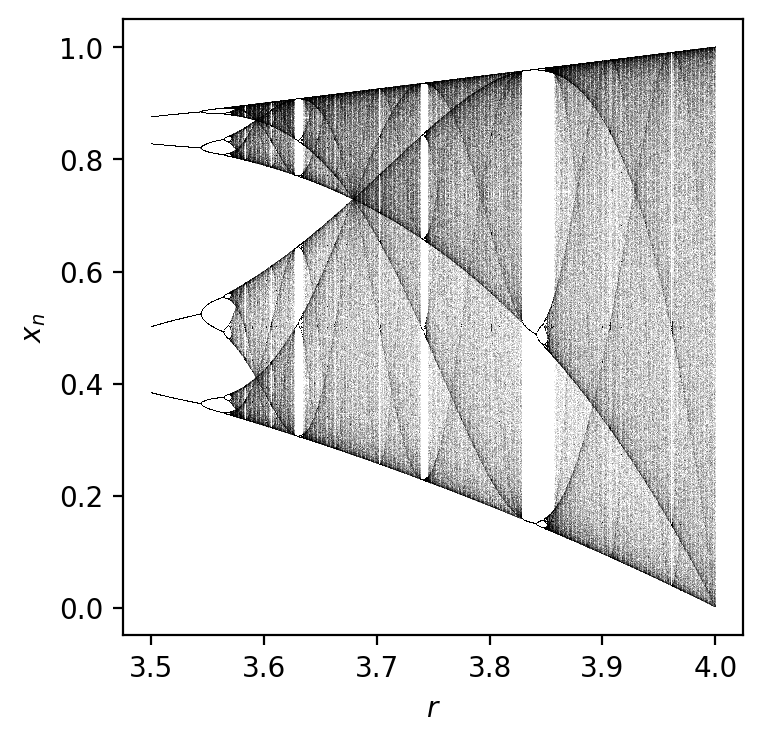

In [4]:
plt.figure(figsize=(4,4),dpi=200)
for ind in range(num):
    plt.plot(np.ones(N)*rs[ind],xss[ind], ',', alpha=0.1, c='black', rasterized=True)
plt.xlabel('$r$')
plt.ylabel('$x_n$')
plt.savefig('logistic.pdf')
plt.show()

We fit a SINDyCP model from four trajectories with differing values of $r$

In [5]:
N=1000
N_drop=500

rs=[3.6,3.7,3.8,3.9]
xss=[]
for r in rs:
    xs=[]
    x=0.5
    for n in range(N+N_drop):
        if n>=N_drop:
            xs=xs+[x]
        x=r*x*(1-x)
    xss=xss+[np.array(xs)]

In [6]:
feature_lib=ps.PolynomialLibrary(degree=3,include_bias=True)
parameter_lib=ps.PolynomialLibrary(degree=1,include_bias=True)
lib=ps.ParameterizedLibrary(feature_library=feature_lib,parameter_library=parameter_lib,num_features=1,num_parameters=1)
opt=ps.STLSQ(threshold=1e-1, normalize_columns=False)
model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'r'], discrete_time=True)
model.fit(xss, u=[np.ones(N)*rs[ind] for ind in range(len(rs))], multiple_trajectories=True)
model.print()


hello
(x)[k+1] = 1.000 r[k] x[k] + -1.000 r[k] x[k]^2


### Fit a parameterized Lorenz model
The Lorenz equations
$$ \dot{x} = \sigma (y - x),$$
$$ \dot{y} = x(\rho - z) - y, $$
$$ \dot{z} = x y - \beta z. $$
depend on 3 parameters, $\sigma$, $\rho$, and $\beta$. We generate 10 trajectories with different parameter values.

In [7]:
start=timeit.default_timer()

dt = .002
num_trajectories=5
scalesigma=1
scalerho=1
scalebeta=1

np.random.seed(100)
sigmas=10 + scalesigma*(np.random.random(num_trajectories)-0.5)
rhos=28*np.ones(num_trajectories) + scalerho*(np.random.random(num_trajectories)-0.5)
betas=2.66667*np.ones(num_trajectories) + scalebeta*(np.random.random(num_trajectories)-0.5)
x_trains=[]
t_trains=[]

for i in range(len(sigmas)):
    t_train = np.arange(0, 10, dt)
    x0_train = [-8, 8, 27]
    t_train_span = (t_train[0], t_train[-1])
    x_train = solve_ivp(lorenz, t_train_span, x0_train, args=(sigmas[i],betas[i],rhos[i]),
                    t_eval=t_train, **integrator_keywords).y.T
    x_trains=x_trains+[x_train]
    t_trains=t_trains+[t_train]

stop=timeit.default_timer()
print(stop-start)

4.8200497769999995


Fitting any one trajectory gives the equation corresponding to a specfic set of parameter values. Can we discover the parameterized equations given all the trajectories?

In [8]:
lib=ps.PolynomialLibrary()
opt=ps.STLSQ(threshold=1e-1, normalize_columns=False)
model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'y', 'z', 'sigma', 'rho', 'beta'])
model.fit(x_trains[-1], t=dt)
model.print()
print([sigmas[-1],rhos[-1],betas[-1]])
print(lib.get_feature_names(['x', 'y', 'z', 'sigma', 'rho', 'beta']))

(x)' = -9.504 x + 9.504 y
(y)' = 28.068 x + -0.999 y + -1.000 x z
(z)' = -2.386 z + 1.000 x y
[9.504718856190973, 28.07509332942725, 2.3863674926249923]
['1', 'x', 'y', 'z', 'x^2', 'x y', 'x z', 'y^2', 'y z', 'z^2']


We use the control input of ps.model to specify the parameter values, and fit a SINDy model with multiple trajectories.

Create list of control inputs corresponding to the parameters. The control inputs have the same shape as the data, but are constant across the temporal grid.

In [9]:
sigmas_timeseries=np.array(sigmas)[:,np.newaxis]*np.ones(t_trains[0].shape[0])[np.newaxis,:]
rhos_timeseries=np.array(rhos)[:,np.newaxis]*np.ones(t_trains[0].shape[0])[np.newaxis,:]
betas_timeseries=np.array(betas)[:,np.newaxis]*np.ones(t_trains[0].shape[0])[np.newaxis,:]
u_trains=[np.concatenate([np.transpose([sigmas_timeseries[i]]),np.transpose([rhos_timeseries[i]]),np.transpose([betas_timeseries[i]])],axis=1) for i in range(num_trajectories)]

Fitting a PolynomialLibrary with multiple_trajectories=True gives the correct model, but note that the same library functions are applied to the input features and the control input.

In [10]:
lib=ps.PolynomialLibrary()
opt=ps.STLSQ(threshold=1e-1, normalize_columns=False)
model = ps.SINDy(feature_library=lib, optimizer=opt, feature_names=['x', 'y', 'z', 'sigma', 'rho', 'beta'])
model.fit(x_trains, u=u_trains, t=dt, multiple_trajectories=True)
model.print()
print(lib.get_feature_names(['x', 'y', 'z', 'sigma', 'rho', 'beta']))

(x)' = -1.000 x sigma + 1.000 y sigma
(y)' = -0.999 y + -1.000 x z + 1.000 x rho
(z)' = 1.000 x y + -1.000 z beta
['1', 'x', 'y', 'z', 'sigma', 'rho', 'beta', 'x^2', 'x y', 'x z', 'x sigma', 'x rho', 'x beta', 'y^2', 'y z', 'y sigma', 'y rho', 'y beta', 'z^2', 'z sigma', 'z rho', 'z beta', 'sigma^2', 'sigma rho', 'sigma beta', 'rho^2', 'rho beta', 'beta^2']


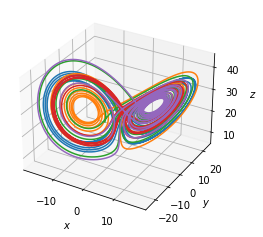

In [11]:
fig = plt.figure(figsize=(4, 4))
ax = plt.axes(projection='3d')

for i in range(num_trajectories):
    ax.plot(x_trains[i][:,0],x_trains[i][:,1],x_trains[i][:,2])
    
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
plt.savefig('lorenz.pdf')
plt.show()

The ParameterizedLibrary enables different libraries to be applied to the control input and input features. In this case, the result is the same, but different libraries are required for the PDE case, as shown below.

In [12]:
feature_library=ps.PolynomialLibrary(degree=4)
parameter_library=ps.PolynomialLibrary(degree=1)
lib=ps.ParameterizedLibrary(feature_library=feature_library,parameter_library=parameter_library, num_parameters=3)
opt=ps.STLSQ(threshold=1e-1, normalize_columns=False)
model = ps.SINDy(feature_library=lib, optimizer=opt, feature_names=['x', 'y', 'z', 'sigma', 'rho', 'beta'])
model.fit(x_trains, u=u_trains, t=dt, multiple_trajectories=True)
model.print()
print(lib.get_feature_names(['x', 'y', 'z', 'sigma', 'rho', 'beta']))

(x)' = -1.000 sigma x + 1.000 sigma y
(y)' = -0.999 1 y + -1.000 1 x z + 1.000 rho x
(z)' = 1.000 1 x y + -1.000 beta z
['1 1', '1 x', '1 y', '1 z', '1 x^2', '1 x y', '1 x z', '1 y^2', '1 y z', '1 z^2', '1 x^3', '1 x^2 y', '1 x^2 z', '1 x y^2', '1 x y z', '1 x z^2', '1 y^3', '1 y^2 z', '1 y z^2', '1 z^3', '1 x^4', '1 x^3 y', '1 x^3 z', '1 x^2 y^2', '1 x^2 y z', '1 x^2 z^2', '1 x y^3', '1 x y^2 z', '1 x y z^2', '1 x z^3', '1 y^4', '1 y^3 z', '1 y^2 z^2', '1 y z^3', '1 z^4', 'sigma 1', 'sigma x', 'sigma y', 'sigma z', 'sigma x^2', 'sigma x y', 'sigma x z', 'sigma y^2', 'sigma y z', 'sigma z^2', 'sigma x^3', 'sigma x^2 y', 'sigma x^2 z', 'sigma x y^2', 'sigma x y z', 'sigma x z^2', 'sigma y^3', 'sigma y^2 z', 'sigma y z^2', 'sigma z^3', 'sigma x^4', 'sigma x^3 y', 'sigma x^3 z', 'sigma x^2 y^2', 'sigma x^2 y z', 'sigma x^2 z^2', 'sigma x y^3', 'sigma x y^2 z', 'sigma x y z^2', 'sigma x z^3', 'sigma y^4', 'sigma y^3 z', 'sigma y^2 z^2', 'sigma y z^3', 'sigma z^4', 'rho 1', 'rho x', 'rho y'

/Users/zack/opt/anaconda3/envs/pysindy_env/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.00381e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/Users/zack/opt/anaconda3/envs/pysindy_env/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.00381e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/Users/zack/opt/anaconda3/envs/pysindy_env/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.00381e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


### Fit a parameterized complex Ginzburg-Landau equation
The complex Ginzburg-Landau equation
$$ \dot{A} = A + (1+ib)\nabla^2 A - (1-ic)|A|^2A$$
describes the evolution of the mode amplitude $A$ for pattern formation in a long-wavelength, supercritical Hopf bifurcation. It depends on two parameters $b$ and $c$. We generate 4 trajectories with different values of the parameters. (Note: this will take 5 minutes)

In [17]:
nx=128
ny=128
N=nx*ny
L=16
t1=2e2
t3=1.9e2
dt=1e-1
nt=int((t1-t3)/dt)
def cgle(t, Z, b, c):
    Zxxr=ps.SpectralDerivative(d=2,axis=0)._differentiate(np.real(Z).reshape((nx,ny)),1.0/nx)
    Zyyr=ps.SpectralDerivative(d=2,axis=1)._differentiate(np.real(Z).reshape((nx,ny)),1.0/ny)
    Zxxi=ps.SpectralDerivative(d=2,axis=0)._differentiate(np.imag(Z).reshape((nx,ny)),1.0/nx)
    Zyyi=ps.SpectralDerivative(d=2,axis=1)._differentiate(np.imag(Z).reshape((nx,ny)),1.0/ny)
    lap=(Zxxr+1j*Zxxi+Zyyr+1j*Zyyi).reshape(N)    
    return Z - (1-1j*c)*Z*Z*Z.conjugate() + (1+1j*b)*lap/(2*np.pi*L)**2


spatial_grid=np.zeros((nx,ny,2))
spatial_grid[:,:,0]=(np.arange(nx)-nx//2)[:,np.newaxis]*2*np.pi*L/nx
spatial_grid[:,:,1]=(np.arange(nx)-nx//2)[np.newaxis,:]*2*np.pi*L/nx
spatiotemporal_grid=np.zeros((nx,ny,100,3))
spatiotemporal_grid[:,:,:,:2]=spatial_grid[:,:,np.newaxis,:]
spatiotemporal_grid[:,:,:,2]=dt*np.arange(100)

In [18]:
bs=[2.0,2.0,0.5,1.0]
cs=[1.0,0.75,0.5,0.75]
scales=[1e-1,1e-1,1e-1,1e0]
scales2=[1e-2,1e-2,1e0,1e-2]

if np.all([os.path.exists('data/cgle/cgle_x'+str(i)+'.npy') for i in range(4)]):
    xs=[np.load('data/cgle/cgle_x'+str(i)+'.npy') for i in range(4)]
    us=[np.load('data/cgle/cgle_u'+str(i)+'.npy') for i in range(4)]
else:
    xs=[]
    for i in range(len(bs)):
        b=bs[i]
        c=cs[i]
        scale0=scales[i]
        scale2=scales2[i]
        start=timeit.default_timer()

        ks=np.arange(-2,3)
        phase_init=np.zeros((nx,ny),dtype=np.complex128)+1
        kx=2
        ky=2
        phase_init = phase_init + scale2*(np.exp(1j*(2*np.pi * kx/nx * np.arange(nx)[:,np.newaxis]+2*np.pi * ky/ny * np.arange(ny)[np.newaxis,:])) - 1)

        np.random.seed(100)
        for kx in ks:
            for ky in ks:
                scale=scale0/(1+(kx**2+ky**2))**0.5
                phase_init += scale*(np.random.normal(0,1)+1j*np.random.normal(0,1))*np.exp(1j*(2*np.pi * kx/nx * np.arange(nx)[:,np.newaxis]+2*np.pi * ky/ny * np.arange(ny)[np.newaxis,:])) 

        phases=np.zeros( [int(t1/dt), N], dtype=np.complex128 )
        phase=phase_init.reshape(N)
        times=[]
        dt1=dt/1000
        for n in range(int(t1/dt)):
            t=n*dt
            print('%.1f'%(t),end='\r')
            sol=solve_ivp(cgle, [t,t+dt], phase, method='RK45', args=(b, c), rtol=1e-6, atol=1e-6, first_step=dt1)
            times.append(sol.t)
            dt1=np.mean(np.diff(sol.t))
            phase=sol.y[:,-1]
            phases[n] = phase

        stop=timeit.default_timer()
        print(stop-start)
        x=np.zeros((nx,ny,nt,2))
        x[:,:,:,0]=np.real(phases.reshape((int(t1/dt),nx,ny))[int(t3/dt):].transpose((1,2,0)))
        x[:,:,:,1]=np.imag(phases.reshape((int(t1/dt),nx,ny))[int(t3/dt):].transpose((1,2,0)))
        xs.append(x)

    #Create list of control inputs corresponding to the parameters. 
    #The control inputs have the same shape as the data, 
    #but are constant across the spatiotemporal grid.
    us=[]
    for i in range(4):
        b=bs[i]
        c=cs[i]
        u=np.zeros(np.concatenate([xs[0].shape[:-1],[2]]))
        u[:,:,:,0]=b
        u[:,:,:,1]=c
        us.append(u)
        
    for i in range(len(xs)):
        np.save('data/cgle/cgle_x'+str(i),xs[i])
        np.save('data/cgle/cgle_u'+str(i),us[i])

Depending on the parameter values and initial conditions, the system exhibits different dynamical phases.

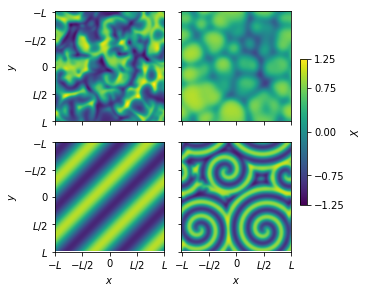

In [20]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig,axs=plt.subplots(2,2,figsize=(5,4), constrained_layout=True)

for i in range(len(xs)):
    plt.subplot(2,2,i+1)
    pl=plt.imshow(xs[i][:,:,-1,0],vmin=-1.25,vmax=1.25)
    plt.gca().set_xticks([0,32,64,96,128])
    plt.gca().set_xticklabels(['$-L$','$-L/2$', '0', '$L/2$', '$L$'])
    plt.gca().set_yticks([0,32,64,96,128])
    plt.gca().set_yticklabels(['$-L$','$-L/2$', '0', '$L/2$', '$L$'])
    if i==2 or i==3:
        plt.xlabel('$x$')
    else:
        plt.gca().set_xticklabels([])
    if i==0 or i==2:
        plt.ylabel('$y$')
    else:
        plt.gca().set_yticklabels([])
    
cbar=plt.colorbar(pl,ax=axs[:,1],orientation="vertical",ticks=[-1.25,-0.75,0.00,0.75,1.25],label='$X$',shrink=0.6)
plt.savefig('cgle.pdf')
plt.show()


In [25]:
xs[0].shape

(128, 128, 100, 2)

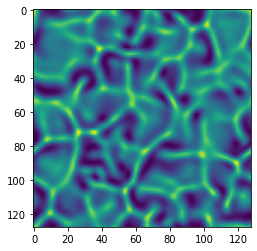

In [24]:
plt.imshow(xs[0][:,:,0,0]**2+xs[0][:,:,0,1]**2)

Fitting any one trajectory gives the equation corresponding to a specfic set of parameter values. Can we discover the parameterized equations given all the trajectories?

In [16]:
start=timeit.default_timer()
lib=ps.PDELibrary(library_functions=[lambda x:x, lambda x:x**3, lambda x,y:x**2*y, lambda x,y:y**2*x],derivative_order=2,spatial_grid=spatial_grid,include_interaction=False,function_names=[lambda x:x, lambda x:x+x+x, lambda x,y:x+x+y,  lambda x,y:x+y+y])
lib.differentiation_method=ps.SpectralDerivative
lib.diff_kwargs={}
opt=ps.STLSQ(threshold=1e-1,alpha=1e-3)
model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['X', 'Y'])
model.fit(xs[-1],t=dt)
model.print()
stop=timeit.default_timer()
print(stop-start)

(X)' = 0.999 X + -0.999 XXX + -0.750 YYY + -0.750 XXY + -0.999 XYY + 1.000 X_22 + -0.999 Y_22 + 1.000 X_11 + -0.999 Y_11
(Y)' = 0.999 Y + 0.750 XXX + -0.999 YYY + -0.999 XXY + 0.750 XYY + 0.999 X_22 + 1.000 Y_22 + 0.999 X_11 + 1.000 Y_11
4.737636062


Try a SINDy model with multiple trajectories using the ParameterizedLibrary. Use a PDELibrary for the feature_library with second-order derivatives and library functions that include the relevant cubic term. Use a PDELibrary for the parameter_library with zeroth-order derivatives and linear library functions. The fit is very good!

In [26]:
start=timeit.default_timer()
library_functions=[lambda x:x, lambda x:x**3, lambda x,y:x**2*y, lambda x,y:y**2*x]
function_names=[lambda x:x, lambda x:x+x+x, lambda x,y:x+x+y,lambda x,y:x+y+y]
feature_lib=ps.PDELibrary(library_functions=library_functions,derivative_order=2,spatial_grid=spatial_grid,include_interaction=False,function_names=function_names)
library_functions=[lambda x:x]
function_names=[lambda x:x]
parameter_lib=ps.PDELibrary(library_functions=library_functions,derivative_order=0,include_interaction=False,function_names=function_names,include_bias=True)
lib=ps.ParameterizedLibrary(parameter_library=parameter_lib,feature_library=feature_lib,num_parameters=2,num_features=2)
opt=ps.STLSQ(threshold=1e-1,alpha=1e-3,normalize_columns=False)
model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'y', 'b', 'c'])
model.fit(xs,u=us,t=dt,multiple_trajectories=True)
model.print()
stop=timeit.default_timer()
print(stop-start)
print(lib.get_feature_names(['x', 'y', 'b', 'c']))

(x)' = 0.988 1 x + -0.987 1 xxx + -0.987 1 xyy + 0.905 1 x_22 + 0.164 1 y_22 + 1.018 1 x_11 + -0.995 b y_22 + -1.019 b y_11 + -0.999 c yyy + -1.000 c xxy + 0.124 c x_22 + -0.221 c y_22
(y)' = 0.990 1 y + -0.989 1 yyy + -0.989 1 xxy + -0.159 1 x_22 + 1.014 1 y_22 + 1.018 1 y_11 + 0.997 b x_22 + 1.020 b x_11 + 0.999 c xxx + 0.999 c xyy + 0.212 c x_22
115.26921940600005
['1 x', '1 y', '1 xxx', '1 yyy', '1 xxy', '1 xyy', '1 x_2', '1 y_2', '1 x_22', '1 y_22', '1 x_1', '1 y_1', '1 x_12', '1 y_12', '1 x_11', '1 y_11', 'b x', 'b y', 'b xxx', 'b yyy', 'b xxy', 'b xyy', 'b x_2', 'b y_2', 'b x_22', 'b y_22', 'b x_1', 'b y_1', 'b x_12', 'b y_12', 'b x_11', 'b y_11', 'c x', 'c y', 'c xxx', 'c yyy', 'c xxy', 'c xyy', 'c x_2', 'c y_2', 'c x_22', 'c y_22', 'c x_1', 'c y_1', 'c x_12', 'c y_12', 'c x_11', 'c y_11']


Modifying PDELibrary to accept spectral derivatives improves the fit a bit

In [18]:
start=timeit.default_timer()
library_functions=[lambda x:x, lambda x:x**3, lambda x,y:x**2*y, lambda x,y:y**2*x]
function_names=[lambda x:x, lambda x:x+x+x, lambda x,y:x+x+y,lambda x,y:x+y+y]
feature_lib=ps.PDELibrary(library_functions=library_functions,derivative_order=2,spatial_grid=spatial_grid,include_interaction=False,function_names=function_names)
feature_lib.differentiation_method=ps.SpectralDerivative
feature_lib.diff_kwargs={}
library_functions=[lambda x:x]
function_names=[lambda x:x]
parameter_lib=ps.PDELibrary(library_functions=library_functions,derivative_order=0,include_interaction=False,function_names=function_names,include_bias=True)
lib=ps.ParameterizedLibrary(parameter_library=parameter_lib,feature_library=feature_lib,num_parameters=2,num_features=2)
opt=ps.STLSQ(threshold=1e-1,alpha=1e-3,normalize_columns=False)
model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'y', 'b', 'c'])
model.fit(xs,u=us,t=dt,multiple_trajectories=True)
model.print()
stop=timeit.default_timer()
print(stop-start)
print(lib.get_feature_names(['x', 'y', 'b', 'c']))

(x)' = 0.999 1 x + -0.999 1 xxx + -0.999 1 xyy + 0.999 1 x_22 + 0.999 1 x_11 + -0.999 b y_22 + -0.999 b y_11 + -0.999 c yyy + -0.999 c xxy
(y)' = 0.999 1 y + -0.999 1 yyy + -0.999 1 xxy + 0.999 1 y_22 + 0.999 1 y_11 + 0.999 b x_22 + 0.999 b x_11 + 0.999 c xxx + 0.999 c xyy
84.92267990500001
['1 x', '1 y', '1 xxx', '1 yyy', '1 xxy', '1 xyy', '1 x_2', '1 y_2', '1 x_22', '1 y_22', '1 x_1', '1 y_1', '1 x_12', '1 y_12', '1 x_11', '1 y_11', 'b x', 'b y', 'b xxx', 'b yyy', 'b xxy', 'b xyy', 'b x_2', 'b y_2', 'b x_22', 'b y_22', 'b x_1', 'b y_1', 'b x_12', 'b y_12', 'b x_11', 'b y_11', 'c x', 'c y', 'c xxx', 'c yyy', 'c xxy', 'c xyy', 'c x_2', 'c y_2', 'c x_22', 'c y_22', 'c x_1', 'c y_1', 'c x_12', 'c y_12', 'c x_11', 'c y_11']


If we ensure the same domain cells are used in the feature library and the parameter library (by reseeding np.random), the WeakLibrary can be used with the ParameterLibrary. (In this case, the parameters need to be constants, so that the tensor product of two WeakLibrary corresponds to the correct weak features.) The fit is perfect and super fast!

In [19]:
start=timeit.default_timer()
np.random.seed(100)
library_functions=[lambda x:x, lambda x:x**3, lambda x,y:x**2*y, lambda x,y:y**2*x]
function_names=[lambda x:x, lambda x:x+x+x, lambda x,y:x+x+y,lambda x,y:x+y+y]
feature_lib=ps.WeakPDELibrary(library_functions=library_functions,derivative_order=2,spatiotemporal_grid=spatiotemporal_grid,include_interaction=False,function_names=function_names,K=500, H_xt=[L*2*np.pi/10,L*2*np.pi/10,(t1-t3)/10])
np.random.seed(100)
library_functions=[lambda x:x]
function_names=[lambda x:x]
parameter_lib=ps.WeakPDELibrary(library_functions=library_functions,spatiotemporal_grid=spatiotemporal_grid,derivative_order=0,include_interaction=False,function_names=function_names,include_bias=True,K=500, H_xt=[L*2*np.pi/10,L*2*np.pi/10,(t1-t3)/10])
lib=ps.ParameterizedLibrary(parameter_library=parameter_lib,feature_library=feature_lib,num_parameters=2,num_features=2)
opt=ps.STLSQ(threshold=1e-1,alpha=1e-3,normalize_columns=False)
model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'y', 'b', 'c'])
model.fit(xs,u=us,t=dt,multiple_trajectories=True)
model.print()
stop=timeit.default_timer()
print(stop-start)
print(lib.get_feature_names(['x', 'y', 'b', 'c']))

(x)' = 1.000 1 x + -1.000 1 xxx + -1.000 1 xyy + 1.000 1 x_22 + 1.000 1 x_11 + -1.000 b y_22 + -1.000 b y_11 + -1.000 c yyy + -1.000 c xxy
(y)' = 1.000 1 y + -1.000 1 yyy + -1.000 1 xxy + 1.000 1 y_22 + 1.000 1 y_11 + 1.000 b x_22 + 1.000 b x_11 + 1.000 c xxx + 1.000 c xyy
17.565542658999988
['1 x', '1 y', '1 xxx', '1 yyy', '1 xxy', '1 xyy', '1 x_2', '1 y_2', '1 x_22', '1 y_22', '1 x_1', '1 y_1', '1 x_12', '1 y_12', '1 x_11', '1 y_11', 'b x', 'b y', 'b xxx', 'b yyy', 'b xxy', 'b xyy', 'b x_2', 'b y_2', 'b x_22', 'b y_22', 'b x_1', 'b y_1', 'b x_12', 'b y_12', 'b x_11', 'b y_11', 'c x', 'c y', 'c xxx', 'c yyy', 'c xxy', 'c xyy', 'c x_2', 'c y_2', 'c x_22', 'c y_22', 'c x_1', 'c y_1', 'c x_12', 'c y_12', 'c x_11', 'c y_11']


### Effects of noise

Generate two new trajectories to for model testing

In [22]:
bs=[2.0, 1.5]
cs=[1.5, 1.0]
scales=[1e-1,1e-1]
scales2=[1e-2,1e-2]


if np.all([os.path.exists('data/cgle/cgle_test_x'+str(i)+'.npy') for i in range(2)]):
    xs_test=[np.load('data/cgle/cgle_test_x'+str(i)+'.npy') for i in range(2)]
    us_test=[np.load('data/cgle/cgle_test_u'+str(i)+'.npy') for i in range(2)]
else:
    xs_test=[]
    for i in range(len(bs)):
        b=bs[i]
        c=cs[i]
        scale0=scales[i]
        scale2=scales2[i]
        start=timeit.default_timer()

        ks=np.arange(-2,3)
        phase_init=np.zeros((nx,ny),dtype=np.complex128)+1
        kx=2
        ky=2
        phase_init = phase_init + scale2*(np.exp(1j*(2*np.pi * kx/nx * np.arange(nx)[:,np.newaxis]+2*np.pi * ky/ny * np.arange(ny)[np.newaxis,:])) - 1)

        np.random.seed(100)
        for kx in ks:
            for ky in ks:
                scale=scale0/(1+(kx**2+ky**2))**0.5
                phase_init += scale*(np.random.normal(0,1)+1j*np.random.normal(0,1))*np.exp(1j*(2*np.pi * kx/nx * np.arange(nx)[:,np.newaxis]+2*np.pi * ky/ny * np.arange(ny)[np.newaxis,:])) 

        phases=np.zeros( [int(t1/dt), N], dtype=np.complex128 )
        phase=phase_init.reshape(N)
        times=[]
        dt1=dt/1000
        for n in range(int(t1/dt)):
            t=n*dt
            print('%.1f'%(t),end='\r')
            sol=solve_ivp(cgle, [t,t+dt], phase, method='RK45', args=(b, c), rtol=1e-6, atol=1e-6, first_step=dt1)
            times.append(sol.t)
            dt1=np.mean(np.diff(sol.t))
            phase=sol.y[:,-1]
            phases[n] = phase

        stop=timeit.default_timer()
        print(stop-start)
        x=np.zeros((nx,ny,nt,2))
        x[:,:,:,0]=np.real(phases.reshape((int(t1/dt),nx,ny))[int(t3/dt):].transpose((1,2,0)))
        x[:,:,:,1]=np.imag(phases.reshape((int(t1/dt),nx,ny))[int(t3/dt):].transpose((1,2,0)))
        xs_test.append(x)

    #Create list of control inputs corresponding to the parameters. 
    #The control inputs have the same shape as the data, 
    #but are constant across the spatiotemporal grid.
    us_test=[]
    for i in range(2):
        b=bs[i]
        c=cs[i]
        u=np.zeros(np.concatenate([xs[0].shape[:-1],[2]]))
        u[:,:,:,0]=b
        u[:,:,:,1]=c
        us_test.append(u)
    
    for i in range(len(xs_test)):
        np.save('data/cgle/cgle_test_x'+str(i),xs_test[i])
        np.save('data/cgle/cgle_test_u'+str(i),us_test[i])

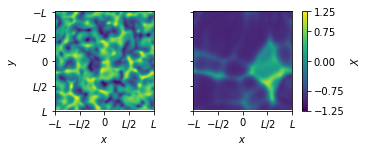

In [23]:
fig,axs=plt.subplots(2,1,figsize=(5,2), constrained_layout=True)

for i in range(len(xs_test)):
    plt.subplot(1,2,i+1)
    pl=plt.imshow(xs_test[i][:,:,-1,0],vmin=-1.25,vmax=1.25)
    plt.gca().set_xticks([0,32,64,96,128])
    plt.gca().set_xticklabels(['$-L$','$-L/2$', '0', '$L/2$', '$L$'])
    plt.gca().set_yticks([0,32,64,96,128])
    plt.gca().set_yticklabels(['$-L$','$-L/2$', '0', '$L/2$', '$L$'])
    if i==0 or i==1:
        plt.xlabel('$x$')
    else:
        plt.gca().set_xticklabels([])
    if i==0 or i==2:
        plt.ylabel('$y$')
    else:
        plt.gca().set_yticklabels([])
    
plt.colorbar(pl,orientation="vertical",ticks=[-1.25,-0.75,0.00,0.75,1.25],label='$X$')
plt.show()


Sweep fits with varying noise intensity

In [24]:
num=10
noisemin=-5
noisemax=-1
intensities=10**(noisemin+np.arange(num)/(num-1)*(noisemax-noisemin))

In [25]:
nscores=[]
nmodels=[]

start=timeit.default_timer()

for scale in intensities:
    print(scale)
    library_functions=[lambda x:x, lambda x:x**3, lambda x,y:x**2*y, lambda x,y:y**2*x]
    function_names=[lambda x:x, lambda x:x+x+x, lambda x,y:x+x+y,lambda x,y:x+y+y]
    feature_lib=ps.PDELibrary(library_functions=library_functions,derivative_order=2,spatial_grid=spatial_grid,include_interaction=False,function_names=function_names)
    feature_lib.differentiation_method=ps.SpectralDerivative
    feature_lib.diff_kwargs={}
    library_functions=[lambda x:x]
    function_names=[lambda x:x]
    parameter_lib=ps.PDELibrary(library_functions=library_functions,derivative_order=0,include_interaction=False,function_names=function_names,include_bias=True)
    lib=ps.ParameterizedLibrary(parameter_library=parameter_lib,feature_library=feature_lib,num_parameters=2,num_features=2)
    opt=ps.STLSQ(threshold=5e-1,alpha=1e-3,normalize_columns=False)
    xs_noisy=[xs[i] + scale*np.random.normal(0,1,size=xs[i].shape) for i in range(len(xs))]
    model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'y', 'b', 'c'])
    model.fit(xs_noisy,u=us,t=dt,multiple_trajectories=True)

    nscores=nscores+[model.score(xs_test,u=us_test,t=dt,multiple_trajectories=True)]
    nmodels=nmodels+[model]
    
stop=timeit.default_timer()
print(stop-start)

1e-05
2.782559402207126e-05
7.742636826811278e-05
0.00021544346900318823
0.0005994842503189409
0.0016681005372000592
0.004641588833612777
0.01291549665014884


/Users/zack/pysindy/pysindy/optimizers/stlsq.py:193: UserWarning: Sparsity parameter is too big (0.5) and eliminated all coefficients
  warnings.warn(


0.03593813663804626


/Users/zack/pysindy/pysindy/optimizers/stlsq.py:183: UserWarning: Sparsity parameter is too big (0.5) and eliminated all coefficients
  warnings.warn(


0.1


/Users/zack/pysindy/pysindy/optimizers/stlsq.py:183: UserWarning: Sparsity parameter is too big (0.5) and eliminated all coefficients
  warnings.warn(


990.5189530060002


In [26]:
nscores_weak=[]
nmodels_weak=[]

start=timeit.default_timer()

for scale in intensities:
    print(scale)
    np.random.seed(100)
    library_functions=[lambda x:x, lambda x:x**3, lambda x,y:x**2*y, lambda x,y:y**2*x]
    function_names=[lambda x:x, lambda x:x+x+x, lambda x,y:x+x+y,lambda x,y:x+y+y]
    feature_lib=ps.WeakPDELibrary(library_functions=library_functions,derivative_order=2,spatiotemporal_grid=spatiotemporal_grid,include_interaction=False,function_names=function_names, K=500, H_xt=[L*2*np.pi/10,L*2*np.pi/10,(t1-t3)/10])
    np.random.seed(100)
    library_functions=[lambda x:x]
    function_names=[lambda x:x]
    parameter_lib=ps.WeakPDELibrary(library_functions=library_functions,spatiotemporal_grid=spatiotemporal_grid,derivative_order=0,include_interaction=False,function_names=function_names,include_bias=True, K=500,H_xt=[L*2*np.pi/10,L*2*np.pi/10,(t1-t3)/10])
    lib=ps.ParameterizedLibrary(parameter_library=parameter_lib,feature_library=feature_lib,num_parameters=2,num_features=2)
    opt=ps.STLSQ(threshold=5e-1,alpha=1e-3,normalize_columns=False)
    xs_noisy=[xs[i] + scale*np.random.normal(0,1,size=xs[i].shape) for i in range(len(xs))]
    model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'y', 'b', 'c'])
    model.fit(xs_noisy,u=us,t=dt,multiple_trajectories=True)

    nscores_weak=nscores_weak+[model.score(xs_test,u=us_test,t=dt,multiple_trajectories=True)]
    nmodels_weak=nmodels_weak+[model]
    
stop=timeit.default_timer()
print(stop-start)

1e-05
2.782559402207126e-05
7.742636826811278e-05
0.00021544346900318823
0.0005994842503189409
0.0016681005372000592
0.004641588833612777
0.01291549665014884
0.03593813663804626
0.1
252.67132267600027


In [30]:
scores0=np.concatenate([np.array(intensities)[:,np.newaxis],np.array(nscores)[:,np.newaxis]],axis=1)
weak_scores0=np.concatenate([np.array(intensities)[:,np.newaxis],np.array(nscores_weak)[:,np.newaxis]],axis=1)
np.save('data/cgle/cgle_scores0',scores0)
np.save('data/cgle/cgle_weak_scores0',weak_scores0)

Generate 5 new trajectories in the amplitude turbulence phase with random parameters

In [31]:
np.random.seed(100)
num_trajectores=5
bs=np.random.normal(1.5,0.5,size=num_trajectores)
cs=np.random.normal(1.0,0.25,size=num_trajectores)
scales=[1e0]*5

if np.all([os.path.exists('data/cgle/cgle_random_x'+str(i)+'.npy') for i in range(num_trajectores)]):
    xs_random=[np.load('data/cgle/cgle_random_x'+str(i)+'.npy') for i in range(num_trajectores)]
    us_random=[np.load('data/cgle/cgle_random_u'+str(i)+'.npy') for i in range(num_trajectores)]
else:
    xs_random=[]
    for i in range(num_trajectores):
        b=bs[i]
        c=cs[i]
        scale0=scales[i]
        start=timeit.default_timer()

        ks=np.arange(-2,3)
        phase_init=np.zeros((nx,ny),dtype=np.complex128)+1
        np.random.seed(100)
        for kx in ks:
            for ky in ks:
                scale=scale0/(1+(kx**2+ky**2))**0.5
                phase_init += scale*(np.random.normal(0,1)+1j*np.random.normal(0,1))*np.exp(1j*(2*np.pi * kx/nx * np.arange(nx)[:,np.newaxis]+2*np.pi * ky/ny * np.arange(ny)[np.newaxis,:])) 

        phases=np.zeros( [int(t1/dt), N], dtype=np.complex128 )
        phase=phase_init.reshape(N)
        times=[]
        dt1=dt/1000
        for n in range(int(t1/dt)):
            t=n*dt
            print('%.1f'%(t),end='\r')
            sol=solve_ivp(cgle, [t,t+dt], phase, method='RK45', args=(b, c), rtol=1e-6, atol=1e-6, first_step=dt1)
            times.append(sol.t)
            dt1=np.mean(np.diff(sol.t))
            phase=sol.y[:,-1]
            phases[n] = phase

        stop=timeit.default_timer()
        print(stop-start)
        x=np.zeros((nx,ny,nt,2))
        x[:,:,:,0]=np.real(phases.reshape((int(t1/dt),nx,ny))[int(t3/dt):].transpose((1,2,0)))
        x[:,:,:,1]=np.imag(phases.reshape((int(t1/dt),nx,ny))[int(t3/dt):].transpose((1,2,0)))
        xs_random.append(x)

    #Create list of control inputs corresponding to the parameters. 
    #The control inputs have the same shape as the data, 
    #but are constant across the spatiotemporal grid.
    us_random=[]
    for i in range(num_trajectores):
        b=bs[i]
        c=cs[i]
        u=np.zeros(np.concatenate([xs[0].shape[:-1],[2]]))
        u[:,:,:,0]=b
        u[:,:,:,1]=c
        us_random.append(u)
        
    for i in range(num_trajectores):
        np.save('data/cgle/cgle_random_x'+str(i),xs_random[i])
        np.save('data/cgle/cgle_random_u'+str(i),us_random[i])

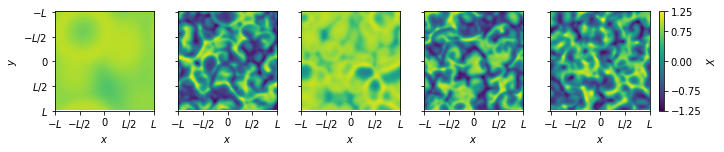

In [32]:
fig,axs=plt.subplots(1,5,figsize=(10,2), constrained_layout=True)

for i in range(len(xs_random)):
    plt.subplot(1,5,i+1)
    pl=plt.imshow(xs_random[i][:,:,-1,0],vmin=-1.25,vmax=1.25)
    plt.gca().set_xticks([0,32,64,96,128])
    plt.gca().set_xticklabels(['$-L$','$-L/2$', '0', '$L/2$', '$L$'])
    plt.gca().set_yticks([0,32,64,96,128])
    plt.gca().set_yticklabels(['$-L$','$-L/2$', '0', '$L/2$', '$L$'])
    plt.xlabel('$x$')
    if i==0:
        plt.ylabel('$y$')
    else:
        plt.gca().set_yticklabels([])
    
plt.colorbar(pl,orientation="vertical",ticks=[-1.25,-0.75,0.00,0.75,1.25],label='$X$')
plt.show()


Repeat the noise intesity sweeps with 4 of these trajectories for comparison

In [33]:
nscores=[]
nmodels=[]

start=timeit.default_timer()

for scale in intensities:
    print(scale)
    library_functions=[lambda x:x, lambda x:x**3, lambda x,y:x**2*y, lambda x,y:y**2*x]
    function_names=[lambda x:x, lambda x:x+x+x, lambda x,y:x+x+y,lambda x,y:x+y+y]
    feature_lib=ps.PDELibrary(library_functions=library_functions,derivative_order=2,spatial_grid=spatial_grid,include_interaction=False,function_names=function_names)
    feature_lib.differentiation_method=ps.SpectralDerivative
    feature_lib.diff_kwargs={}
    library_functions=[lambda x:x]
    function_names=[lambda x:x]
    parameter_lib=ps.PDELibrary(library_functions=library_functions,derivative_order=0,include_interaction=False,function_names=function_names,include_bias=True)
    lib=ps.ParameterizedLibrary(parameter_library=parameter_lib,feature_library=feature_lib,num_parameters=2,num_features=2)
    opt=ps.STLSQ(threshold=5e-1,alpha=1e-3,normalize_columns=False)
    xs_noisy=[xs[i] + scale*np.random.normal(0,1,size=xs[i].shape) for i in range(len(xs))]
    model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'y', 'b', 'c'])
    model.fit(xs_noisy,u=us,t=dt,multiple_trajectories=True)

    nscores=nscores+[model.score(xs_test,u=us_test,t=dt,multiple_trajectories=True)]
    nmodels=nmodels+[model]
    
stop=timeit.default_timer()
print(stop-start)

1e-05
2.782559402207126e-05
7.742636826811278e-05
0.00021544346900318823
0.0005994842503189409
0.0016681005372000592
0.004641588833612777
0.01291549665014884
0.03593813663804626


/Users/zack/pysindy/pysindy/optimizers/stlsq.py:183: UserWarning: Sparsity parameter is too big (0.5) and eliminated all coefficients
  warnings.warn(


0.1


/Users/zack/pysindy/pysindy/optimizers/stlsq.py:183: UserWarning: Sparsity parameter is too big (0.5) and eliminated all coefficients
  warnings.warn(


1050.648142137


Sweep fits with varying number and length of trajectories

In [34]:
nscores_weak=[]
nmodels_weak=[]

start=timeit.default_timer()

for scale in intensities:
    print(scale)
    np.random.seed(100)
    library_functions=[lambda x:x, lambda x:x**3, lambda x,y:x**2*y, lambda x,y:y**2*x]
    function_names=[lambda x:x, lambda x:x+x+x, lambda x,y:x+x+y,lambda x,y:x+y+y]
    feature_lib=ps.WeakPDELibrary(library_functions=library_functions,derivative_order=2,spatiotemporal_grid=spatiotemporal_grid,include_interaction=False,function_names=function_names, K=500, H_xt=[L*2*np.pi/10,L*2*np.pi/10,(t1-t3)/10])
    np.random.seed(100)
    library_functions=[lambda x:x]
    function_names=[lambda x:x]
    parameter_lib=ps.WeakPDELibrary(library_functions=library_functions,spatiotemporal_grid=spatiotemporal_grid,derivative_order=0,include_interaction=False,function_names=function_names,include_bias=True, K=500,H_xt=[L*2*np.pi/10,L*2*np.pi/10,(t1-t3)/10])
    lib=ps.ParameterizedLibrary(parameter_library=parameter_lib,feature_library=feature_lib,num_parameters=2,num_features=2)
    opt=ps.STLSQ(threshold=5e-1,alpha=1e-3,normalize_columns=False)
    xs_noisy=[xs[i] + scale*np.random.normal(0,1,size=xs[i].shape) for i in range(len(xs))]
    model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'y', 'b', 'c'])
    model.fit(xs_noisy,u=us,t=dt,multiple_trajectories=True)

    nscores_weak=nscores_weak+[model.score(xs_test,u=us_test,t=dt,multiple_trajectories=True)]
    nmodels_weak=nmodels_weak+[model]
    
stop=timeit.default_timer()
print(stop-start)

1e-05
2.782559402207126e-05
7.742636826811278e-05
0.00021544346900318823
0.0005994842503189409
0.0016681005372000592
0.004641588833612777
0.01291549665014884
0.03593813663804626
0.1
253.6228248510006


In [35]:
scores1=np.concatenate([np.array(intensities)[:,np.newaxis],np.array(nscores)[:,np.newaxis]],axis=1)
weak_scores1=np.concatenate([np.array(intensities)[:,np.newaxis],np.array(nscores_weak)[:,np.newaxis]],axis=1)
np.save('data/cgle/cgle_scores1',scores1)
np.save('data/cgle/cgle_weak_scores1',weak_scores1)

Sweep fits with varying number and length of trajectories

In [37]:
nums=[2,3,4,5]
nts=[25,50,75,100]

start=timeit.default_timer()
weak_scoreses=[]
weak_sampleses=[]
weak_modelses=[]
for num in nums:
    scores=[]
    samples=[]
    models=[]
    for nt in nts:
        print(num,nt,end='  \r')
        np.random.seed(100)
        library_functions=[lambda x:x, lambda x:x**3, lambda x,y:x**2*y, lambda x,y:y**2*x]
        function_names=[lambda x:x, lambda x:x+x+x, lambda x,y:x+x+y,lambda x,y:x+y+y]
        T=spatiotemporal_grid[0,0,nt-1,-1]-spatiotemporal_grid[0,0,0,-1]
        feature_lib=ps.WeakPDELibrary(library_functions=library_functions,derivative_order=2,spatiotemporal_grid=spatiotemporal_grid[:,:,:nt],include_interaction=False,function_names=function_names, K=500, H_xt=[L*2*np.pi/10,L*2*np.pi/10,T/10])
        np.random.seed(100)
        library_functions=[lambda x:x]
        function_names=[lambda x:x]
        parameter_lib=ps.WeakPDELibrary(library_functions=library_functions,spatiotemporal_grid=spatiotemporal_grid[:,:,:nt],derivative_order=0,include_interaction=False,function_names=function_names,include_bias=True, K=500,H_xt=[L*2*np.pi/10,L*2*np.pi/10,T/10])
        lib=ps.ParameterizedLibrary(parameter_library=parameter_lib,feature_library=feature_lib,num_parameters=2,num_features=2)
        opt=ps.STLSQ(threshold=5e-1,alpha=1e-3,normalize_columns=False)
        scale=1e-3
        shape=np.array(xs_random[i].shape)
        shape[-2]=nt
        xs_noisy=[xs_random[i][:,:,:nt] + scale*np.random.normal(0,1,size=shape) for i in range(num)]
        us_noisy=[us_random[i][:,:,:nt] for i in range(num)]
        model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'y', 'b', 'c'])
        model.fit(xs_noisy,u=us_noisy,t=dt,multiple_trajectories=True)

        scores=scores+[model.score(xs_test,u=us_test,t=dt,multiple_trajectories=True)]
        samples=samples+[np.sum([np.product(xs_noisy[i].shape[:3]) for i in range(len(xs_noisy))])]
        models=models+[model]
    weak_scoreses=weak_scoreses+[scores]
    weak_sampleses=weak_sampleses+[samples]
    weak_modelses=weak_modelses+[models]
stop=timeit.default_timer()
print(stop-start)

315.46903002199997


In [ ]:
nums=[2,3,4,5]
nts=[25,50,75,100]

start=timeit.default_timer()
scoreses=[]
sampleses=[]
modelses=[]
for num in nums:
    scores=[]
    samples=[]
    models=[]
    for nt in nts:
        print(num,nt,end='  \r')
        library_functions=[lambda x:x, lambda x:x**3, lambda x,y:x**2*y, lambda x,y:y**2*x]
        function_names=[lambda x:x, lambda x:x+x+x, lambda x,y:x+x+y,lambda x,y:x+y+y]
        feature_lib=ps.PDELibrary(library_functions=library_functions,derivative_order=2,spatial_grid=spatial_grid,include_interaction=False,function_names=function_names)
        feature_lib.differentiation_method=ps.SpectralDerivative
        feature_lib.diff_kwargs={}
        library_functions=[lambda x:x]
        function_names=[lambda x:x]
        parameter_lib=ps.PDELibrary(library_functions=library_functions,derivative_order=0,include_interaction=False,function_names=function_names,include_bias=True)
        lib=ps.ParameterizedLibrary(parameter_library=parameter_lib,feature_library=feature_lib,num_parameters=2,num_features=2)
        opt=ps.STLSQ(threshold=5e-1,alpha=1e-3,normalize_columns=False)
        scale=1e-3
        shape=np.array(xs_random[i].shape)
        shape[-2]=nt
        xs_noisy=[xs_random[i][:,:,:nt] + scale*np.random.normal(0,1,size=shape) for i in range(num)]
        us_noisy=[us_random[i][:,:,:nt] for i in range(num)]
        model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'y', 'b', 'c'])
        model.fit(xs_noisy,u=us_noisy,t=dt,multiple_trajectories=True)

        scores=scores+[model.score(xs_test,u=us_test,t=dt,multiple_trajectories=True)]
        samples=samples+[np.sum([np.product(xs_noisy[i].shape[:3]) for i in range(len(xs_noisy))])]
        models=models+[model]
    scoreses=scoreses+[scores]
    sampleses=sampleses+[samples]
    modelses=modelses+[models]
stop=timeit.default_timer()
print(stop-start)

In [ ]:
scores2=np.concatenate([np.array(sampleses)[:,:,np.newaxis],np.array(scoreses)[:,:,np.newaxis]],axis=2)
weak_scores2=np.concatenate([np.array(weak_sampleses)[:,:,np.newaxis],np.array(weak_scoreses)[:,:,np.newaxis]],axis=2)
np.save('data/cgle/cgle_scores2',scores2)
np.save('data/cgle/cgle_weak_scores2',weak_scores2)

Plot results

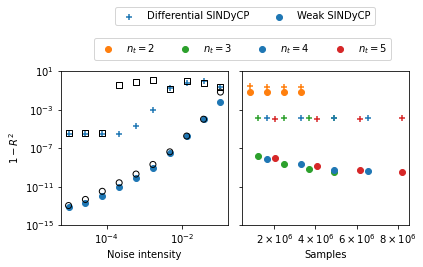

In [67]:
colors=['#ff7f0e', '#2ca02c', '#1f77b4','#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

fig,ax=plt.subplots(1,2,figsize=(6,3))

plt.subplot(1,2,1)
scores0=np.load('data/cgle/cgle_scores0.npy')
weak_scores0=np.load('data/cgle/cgle_weak_scores0.npy')
scores1=np.load('data/cgle/cgle_scores1.npy')
weak_scores1=np.load('data/cgle/cgle_weak_scores1.npy')
plt.scatter(scores1[:,0],1-scores1[:,1], label='Differential SINDyCP', color=colors[2], marker='+')
plt.scatter(weak_scores1[:,0],1-weak_scores1[:,1], label='Weak SINDyCP', color=colors[2])
plt.scatter(scores0[:,0],1-scores0[:,1],  color=colors[2], marker='s',facecolor='none',edgecolor='black')
plt.scatter(weak_scores0[:,0],1-weak_scores0[:,1],  color=colors[2],facecolor='none',edgecolor='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Noise intensity')
plt.ylabel('$1-R^2$')
plt.ylim(10**-15,10)


plt.subplot(1,2,2)
scores2=np.load('data/cgle/cgle_scores2.npy')
weak_scores2=np.load('data/cgle/cgle_weak_scores2.npy')
for i in range(len(scores2)):
    samples=scores2[i,:,0]
    scores=scores2[i,:,1]
    plt.scatter(samples,1-scores,marker='+',c=colors[i])

for i in range(len(weak_scores2)):
    samples=weak_scores2[i,:,0]
    scores=weak_scores2[i,:,1]
    plt.scatter(samples,1-scores,label=r'$n_t='+str(nums[i])+'$', c=colors[i])


plt.ylim(10**-15,10)
plt.yscale('log')
plt.xlabel('Samples')

ax[0].set_yticks([10**-15,10**-11,10**-7,10**-3,10**1,])

ax[1].set_yticks([10**-15,10**-11,10**-7,10**-3,10**1,])
ax[1].set_yticklabels([])
ax[1].set_xticks([2*10**6,4*10**6,6*10**6,8*10**6])
ax[1].set_xticklabels([r'$2\times 10^6$',r'$4\times 10^6$',r'$6\times 10^6$',r'$8\times 10^6$'])

plt.tight_layout()
ax1=ax[0]
ax2=ax[1]
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1, l1,  bbox_to_anchor=(0,1.6, 2.2,-0.15), loc=9, ncol=4)
ax2.legend(h2, l2,  bbox_to_anchor=(-1.1,1.4, 2.2,-0.15), loc=9, ncol=4)

plt.savefig('fig3.pdf')
plt.show()


### animation

In [5]:
xs=[np.load('data/cgle/cgle_x'+str(i)+'.npy') for i in range(4)]
us=[np.load('data/cgle/cgle_u'+str(i)+'.npy') for i in range(4)]
bs=[us[i][0,0,0,0] for i in range(4)]
cs=[us[i][0,0,0,1] for i in range(4)]

xs_animation=[]
t1=100

for i in range(len(bs)):
    b=bs[i]
    c=cs[i]
    phase_init = xs[i][:,:,-1,0]+1j*xs[i][:,:,-1,1]
    phases=np.zeros( [int(t1/dt), N], dtype=np.complex128 )
    phase=phase_init.reshape(N)
    dt1=dt/1000
    start=timeit.default_timer()
    for n in range(int(t1/dt)):
        t=n*dt
        print('%.1f'%(t),end='\r')
        sol=solve_ivp(cgle, [t,t+dt], phase, method='RK45', args=(b, c), rtol=1e-6, atol=1e-6, first_step=dt1)
        dt1=np.mean(np.diff(sol.t))
        phase=sol.y[:,-1]
        phases[n] = phase

    stop=timeit.default_timer()
    print(stop-start)
    x=np.zeros((nx,ny,int(t1/dt),2))
    x[:,:,:,0]=np.real(phases.reshape((int(t1/dt),nx,ny)).transpose((1,2,0)))
    x[:,:,:,1]=np.imag(phases.reshape((int(t1/dt),nx,ny)).transpose((1,2,0)))
    xs_animation.append(x)

83.30919643899999
70.08276106800001
48.61633189
40.352203793


In [6]:
if not os.path.exists('animation'):
    os.mkdir('animation')

for n in range(xs_animation[0].shape[2]):
    print(n,end='  \r')
    fig,axs=plt.subplots(2,2,figsize=(5,4), constrained_layout=True)
    for i in range(len(xs_animation)):
        plt.subplot(2,2,i+1)
        pl=plt.imshow(xs_animation[i][:,:,n,0],vmin=-1.25,vmax=1.25)
        plt.gca().set_xticks([0,32,64,96,128])
        plt.gca().set_xticklabels(['$-L$','$-L/2$', '0', '$L/2$', '$L$'])
        plt.gca().set_yticks([0,32,64,96,128])
        plt.gca().set_yticklabels(['$-L$','$-L/2$', '0', '$L/2$', '$L$'])
        if i==2 or i==3:
            plt.xlabel('$x$')
        else:
            plt.gca().set_xticklabels([])
        if i==0 or i==2:
            plt.ylabel('$y$')
        else:
            plt.gca().set_yticklabels([])

    cbar=plt.colorbar(pl,ax=axs[:,1],orientation="vertical",ticks=[-1.25,-0.75,0.00,0.75,1.25],label='$X$',shrink=0.6)
    plt.savefig('animation/%04d.png'%(n),pad_inches=0.5,dpi=200,bbox_inches='tight')
    plt.close()


In [53]:
if not os.path.exists('animation'):
    os.mkdir('animation')

start=timeit.default_timer()
for n in range(xs_animation[0].shape[2]):
    print(n,end='  \r')
    fig,axs=plt.subplots(2,2,figsize=(5,4.5), constrained_layout=True)
    for i in range(len(xs_animation)):
        plt.subplot(2,2,i+1)
        phase=(np.arctan2(xs_animation[i][:,:,n,0],xs_animation[i][:,:,n,1])+np.pi)/(2*np.pi)
        amp=(xs_animation[i][:,:,n,0]**2+xs_animation[i][:,:,n,1]**2)**0.5/1.5
        plot=np.flip(np.triu(amp)+np.tril(phase,k=-1),axis=0)
        pl=plt.imshow(plot,vmin=0,vmax=1,cmap='twilight')
        plt.gca().set_xticks([0,32,64,96,128])
        plt.gca().set_xticklabels(['$-L$','$-L/2$', '0', '$L/2$', '$L$'])
        plt.gca().set_yticks([0,32,64,96,128])
        plt.gca().set_yticklabels(['$-L$','$-L/2$', '0', '$L/2$', '$L$'])
        if i==2 or i==3:
            plt.xlabel('$x$')
        else:
            plt.gca().set_xticklabels([])
        if i==0 or i==2:
            plt.ylabel('$y$')
        else:
            plt.gca().set_yticklabels([])

    cbar2=plt.colorbar(pl,ax=axs[:,:],orientation="horizontal",location='top',ticks=[0,0.25,0.5,0.75,1],label='$\phi/2\pi$',shrink=0.6)
    cbar=plt.colorbar(pl,ax=axs[:,:],orientation="vertical",ticks=[0,0.25,0.5,0.75,1],label='$r/1.5$',shrink=0.6)
    plt.savefig('animation/%04d.png'%(n),pad_inches=0.5,dpi=200,bbox_inches='tight')
    plt.close()
    
stop=timeit.default_timer()
print(stop-start)


1501.6216267569998


### Swift Hohenberg $\dot{u}= ru-(\nabla^2+1)^2u+b_3 u^3 - b_5 u^5$

In [32]:
nx=256
N=nx
L=2*np.pi*32
t1=10
t3=0

dt=0.01

nt=int((t1-t3)/dt)
def sh(t, u, r,b3,b5):
    uxx=ps.SpectralDerivative(d=2,axis=0)._differentiate(u,L/nx)
    uxxxx=ps.SpectralDerivative(d=4,axis=0)._differentiate(u,L/nx)
    return r*u - uxxxx - 2*uxx - u + b3*u**3 - b5*u**5

spatial_grid=np.zeros((nx,1))
spatial_grid[:,0]=(np.arange(nx)-nx//2)*L/nx
spatiotemporal_grid=np.zeros((nx,int(t1/dt),2))
spatiotemporal_grid[:,:,:1]=spatial_grid[:,np.newaxis,:]
spatiotemporal_grid[:,:,1]=dt*np.arange(int(t1/dt))

In [33]:
np.random.seed(66)
order=3
rcoeff=2*(np.random.random(size=order)-0.5)/10**np.arange(order)
b3coeff=10*(np.random.random(size=order)-0.5)/10**np.arange(order)
b5coeff=1*(np.random.random(size=order))/10**np.arange(order)
def r_func(epsilons):
    epsilons=np.asarray(epsilons)
    return np.sum(rcoeff[np.newaxis,:]*epsilons[:,np.newaxis]**np.arange(len(rcoeff))[np.newaxis,:],axis=1)

def b3_func(epsilons):
    epsilons=np.asarray(epsilons)
    return np.sum(b3coeff[np.newaxis,:]*epsilons[:,np.newaxis]**np.arange(len(b3coeff))[np.newaxis,:],axis=1)

def b5_func(epsilons):
    epsilons=np.asarray(epsilons)
    return np.sum(b5coeff[np.newaxis,:]*epsilons[:,np.newaxis]**np.arange(len(b5coeff))[np.newaxis,:],axis=1)

epsilons=np.arange(0,3,0.1)
inds=np.intersect1d(np.where(r_func(epsilons)<0)[0],np.where(b3_func(epsilons)>0)[0])

In [34]:
t1=10
t3=0
dt=0.01

num_trajectories=3
np.random.seed(1)
epsilons_train=1+2*(np.random.random(size=num_trajectories))
rs=r_func(epsilons_train)
b3s=b3_func(epsilons_train)
b5s=b5_func(epsilons_train)
k=2

np.random.seed(10)

xs=[]
for i in range(len(rs)):
    r=rs[i]
    b3=b3s[i]
    b5=b5s[i]
    ks=np.arange(-20,21)
    u0=np.zeros((nx),dtype=np.complex128)
    scale0=1.0
    for kx in ks:
        scale=scale0/(1+np.abs(kx)**0.5)
        u0 += scale*(np.random.normal(0,1)+1j*np.random.normal(0,1))*np.exp(1j*(2*np.pi * kx/nx * np.arange(nx))) 

    u=np.real(u0)
    us=np.zeros((int(t1/dt),nx))

    t=0
    for n in range(int(t1/dt)):
        t=n*dt
        print('%d %.1f'%(i, t/t1),end='\r')
        sol=solve_ivp(sh, [t,t+dt], u, method='RK45', args=(r,b3,b5), rtol=1e-6, atol=1e-6, first_step=dt/100)
        u=sol.y[:,-1]
        us[n] = u
    xs.append(np.transpose(us)[:,:,np.newaxis])
    
#Create list of control inputs corresponding to the parameters. 
#The control inputs have the same shape as the data, 
#but are constant across the spatiotemporal grid.
us=[]
u2s=[]
for i in range(len(rs)):
    u=np.zeros(np.concatenate([xs[0].shape[:-1],[3]]))
    u2=np.zeros(np.concatenate([xs[0].shape[:-1],[1]]))
    u[:,:,0]=rs[i]
    u[:,:,1]=b3s[i]
    u[:,:,2]=b5s[i]
    u2[:,:,0]=epsilons_train[i]
    us.append(u)
    u2s.append(u2)

Fit the data with weak SINDyCP

In [71]:
start=timeit.default_timer()
library_functions=[lambda x:x, lambda x:x**3, lambda x: x**5]
function_names=[lambda x:x, lambda x:x+x+x, lambda x: x+x+x+x+x]
seed=2
np.random.seed(seed)
feature_lib=ps.WeakPDELibrary(library_functions=library_functions,derivative_order=4,spatiotemporal_grid=spatiotemporal_grid,include_interaction=False,function_names=function_names,K=500,H_xt=[L/20,10/20])
feature_lib.differentiation_method=ps.SpectralDerivative
feature_lib.diff_kwargs={}
library_functions=[lambda x:x,lambda x:x**2]
function_names=[lambda x:x,lambda x:x+'^2']
np.random.seed(seed)
parameter_lib=ps.WeakPDELibrary(library_functions=library_functions,derivative_order=0,spatiotemporal_grid=spatiotemporal_grid,include_interaction=False,function_names=function_names,include_bias=True,K=500,H_xt=[L/20,10/20])
lib=ps.ParameterizedLibrary(parameter_library=parameter_lib,feature_library=feature_lib,num_parameters=1,num_features=1)
opt=ps.STLSQ(threshold=1e-3,alpha=1e-4,normalize_columns=False)
model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['u', 'epsilon'])
noise_scale=0.01
xs_noisy=[xs[i]*(1+noise_scale*np.random.normal(size=xs[i].shape)) for i in range(len(xs))]
model.fit(xs_noisy,u=u2s,t=dt,multiple_trajectories=True,unbias=True)
model.print()
stop=timeit.default_timer()
print(stop-start)
print(lib.get_feature_names(['u', 'epsilon']))
print(model.score(xs,u=u2s,t=dt,multiple_trajectories=True))

(u)' = -1.695 1 u + 1.795 1 uuu + -0.743 1 uuuuu + -0.031 1 u_1 + -2.007 1 u_11 + -0.024 1 u_111 + -1.017 1 u_1111 + -0.068 epsilon u + -0.334 epsilon uuu + -0.037 epsilon uuuuu + 0.039 epsilon u_1 + 0.012 epsilon u_11 + 0.030 epsilon u_111 + 0.037 epsilon u_1111 + -0.004 epsilon^2 u + -0.010 epsilon^2 uuu + -0.022 epsilon^2 uuuuu + -0.011 epsilon^2 u_1 + -0.001 epsilon^2 u_11 + -0.009 epsilon^2 u_111 + -0.008 epsilon^2 u_1111
2.711518464002438
['1 u', '1 uuu', '1 uuuuu', '1 u_1', '1 u_11', '1 u_111', '1 u_1111', 'epsilon u', 'epsilon uuu', 'epsilon uuuuu', 'epsilon u_1', 'epsilon u_11', 'epsilon u_111', 'epsilon u_1111', 'epsilon^2 u', 'epsilon^2 uuu', 'epsilon^2 uuuuu', 'epsilon^2 u_1', 'epsilon^2 u_11', 'epsilon^2 u_111', 'epsilon^2 u_1111']
0.9999982418676758


Fit results

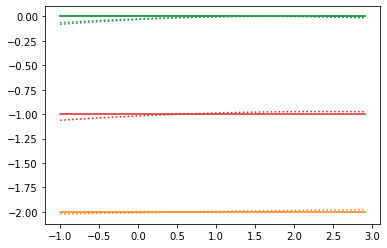

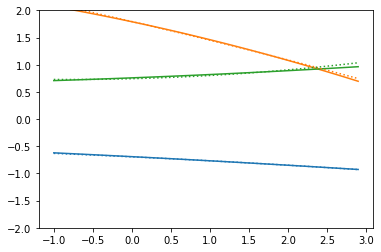

In [72]:
uxcoeff_fit=np.array([opt.coef_[0,np.where(np.array(model.get_feature_names())=='1 u_1')[0][0]],opt.coef_[0,np.where(np.array(model.get_feature_names())=='epsilon u_1')[0][0]],opt.coef_[0,np.where(np.array(model.get_feature_names())=='epsilon^2 u_1')[0][0]]])
uxxcoeff_fit=np.array([opt.coef_[0,np.where(np.array(model.get_feature_names())=='1 u_11')[0][0]],opt.coef_[0,np.where(np.array(model.get_feature_names())=='epsilon u_11')[0][0]],opt.coef_[0,np.where(np.array(model.get_feature_names())=='epsilon^2 u_11')[0][0]]])
uxxxcoeff_fit=np.array([opt.coef_[0,np.where(np.array(model.get_feature_names())=='1 u_111')[0][0]],opt.coef_[0,np.where(np.array(model.get_feature_names())=='epsilon u_111')[0][0]],opt.coef_[0,np.where(np.array(model.get_feature_names())=='epsilon^2 u_111')[0][0]]])
uxxxxcoeff_fit=np.array([opt.coef_[0,np.where(np.array(model.get_feature_names())=='1 u_1111')[0][0]],opt.coef_[0,np.where(np.array(model.get_feature_names())=='epsilon u_1111')[0][0]],opt.coef_[0,np.where(np.array(model.get_feature_names())=='epsilon^2 u_1111')[0][0]]])
def ux_func_fit(epsilons):
    epsilons=np.asarray(epsilons)
    return np.sum(uxcoeff_fit[np.newaxis,:]*epsilons[:,np.newaxis]**np.arange(len(rcoeff))[np.newaxis,:],axis=1)
def uxx_func_fit(epsilons):
    epsilons=np.asarray(epsilons)
    return np.sum(uxxcoeff_fit[np.newaxis,:]*epsilons[:,np.newaxis]**np.arange(len(rcoeff))[np.newaxis,:],axis=1)
def uxxx_func_fit(epsilons):
    epsilons=np.asarray(epsilons)
    return np.sum(uxxxcoeff_fit[np.newaxis,:]*epsilons[:,np.newaxis]**np.arange(len(rcoeff))[np.newaxis,:],axis=1)
def uxxxx_func_fit(epsilons):
    epsilons=np.asarray(epsilons)
    return np.sum(uxxxxcoeff_fit[np.newaxis,:]*epsilons[:,np.newaxis]**np.arange(len(rcoeff))[np.newaxis,:],axis=1)
line1=plt.plot(epsilons,np.ones(shape=epsilons.shape)*0)
line2=plt.plot(epsilons,np.ones(shape=epsilons.shape)*-2)
line3=plt.plot(epsilons,np.ones(shape=epsilons.shape)*0)
line4=plt.plot(epsilons,np.ones(shape=epsilons.shape)*-1)
plt.plot(epsilons,ux_func_fit(epsilons),c=line1[0].get_c(),ls=':')
plt.plot(epsilons,uxx_func_fit(epsilons),c=line2[0].get_c(),ls=':')
plt.plot(epsilons,uxxx_func_fit(epsilons),c=line3[0].get_c(),ls=':')
plt.plot(epsilons,uxxxx_func_fit(epsilons),c=line4[0].get_c(),ls=':')
plt.show()

rcoeff_fit=np.array([opt.coef_[0,np.where(np.array(model.get_feature_names())=='1 u')[0][0]]+1,opt.coef_[0,np.where(np.array(model.get_feature_names())=='epsilon u')[0][0]],opt.coef_[0,np.where(np.array(model.get_feature_names())=='epsilon^2 u')[0][0]]])
b3coeff_fit=np.array([opt.coef_[0,np.where(np.array(model.get_feature_names())=='1 uuu')[0][0]],opt.coef_[0,np.where(np.array(model.get_feature_names())=='epsilon uuu')[0][0]],opt.coef_[0,np.where(np.array(model.get_feature_names())=='epsilon^2 uuu')[0][0]]])
b5coeff_fit=np.array([-opt.coef_[0,np.where(np.array(model.get_feature_names())=='1 uuuuu')[0][0]],-opt.coef_[0,np.where(np.array(model.get_feature_names())=='epsilon uuuuu')[0][0]],-opt.coef_[0,np.where(np.array(model.get_feature_names())=='epsilon^2 uuuuu')[0][0]]])

def r_func_fit(epsilons):
    epsilons=np.asarray(epsilons)
    return np.sum(rcoeff_fit[np.newaxis,:]*epsilons[:,np.newaxis]**np.arange(len(rcoeff))[np.newaxis,:],axis=1)

def b3_func_fit(epsilons):
    epsilons=np.asarray(epsilons)
    return np.sum(b3coeff_fit[np.newaxis,:]*epsilons[:,np.newaxis]**np.arange(len(b3coeff))[np.newaxis,:],axis=1)

def b5_func_fit(epsilons):
    epsilons=np.asarray(epsilons)
    return np.sum(b5coeff_fit[np.newaxis,:]*epsilons[:,np.newaxis]**np.arange(len(b5coeff))[np.newaxis,:],axis=1)

line1=plt.plot(epsilons,r_func(epsilons), label='$d$')
line2=plt.plot(epsilons,b3_func(epsilons),label='$e$')
line3=plt.plot(epsilons,b5_func(epsilons),label='$f$')
plt.plot(epsilons,r_func_fit(epsilons), label='$d$',ls=':',c=line1[0].get_c())
plt.plot(epsilons,b3_func_fit(epsilons),label='$e$',ls=':',c=line2[0].get_c())
plt.plot(epsilons,b5_func_fit(epsilons),label='$f$',ls=':',c=line3[0].get_c())
plt.ylim(-2,2)

plt.show()

In [67]:
print('P=((%.16e)+(%.16e)*E+(%.16e)*E*E)/((%.16e)+(%.16e)*E+(%.16e)*E*E)'%(uxxcoeff_fit[0],uxxcoeff_fit[1],uxxcoeff_fit[2],uxxxxcoeff_fit[0],uxxxxcoeff_fit[1],uxxxxcoeff_fit[2]))
print('R=1-((%.16e)+(%.16e)*E+(%.16e)*E*E)/((%.16e)+(%.16e)*E+(%.16e)*E*E)'%(rcoeff_fit[0]-1,rcoeff_fit[1],rcoeff_fit[2],uxxxxcoeff_fit[0],uxxxxcoeff_fit[1],uxxxxcoeff_fit[2]))
print('B=((%.16e)+(%.16e)*E+(%.16e)*E*E)/((%.16e)+(%.16e)*E+(%.16e)*E*E)'%(-b3coeff_fit[0],-b3coeff_fit[1],-b3coeff_fit[2],uxxxxcoeff_fit[0],uxxxxcoeff_fit[1],uxxxxcoeff_fit[2]))
print('C=((%.16e)+(%.16e)*E+(%.16e)*E*E)/((%.16e)+(%.16e)*E+(%.16e)*E*E)'%(-b5coeff_fit[0],-b5coeff_fit[1],-b5coeff_fit[2],uxxxxcoeff_fit[0],uxxxxcoeff_fit[1],uxxxxcoeff_fit[2]))


P=((-1.9705066324056859e+00)+(-3.3886219976459464e-02)*E+(9.0881146946531332e-03)*E*E)/((-8.7343988274258810e-01)+(-1.4939983606044457e-01)*E+(4.0443274400885187e-02)*E*E)
R=1-((-1.6876661964344961e+00)+(-7.6322945264545694e-02)*E+(-2.2985785743823328e-03)*E*E)/((-8.7343988274258810e-01)+(-1.4939983606044457e-01)*E+(4.0443274400885187e-02)*E*E)
B=((-1.7692079519934829e+00)+(3.1029611934245738e-01)*E+(1.6698713776882507e-02)*E*E)/((-8.7343988274258810e-01)+(-1.4939983606044457e-01)*E+(4.0443274400885187e-02)*E*E)
C=((-7.8005618451154768e-01)+(2.7149901115639221e-02)*E+(-4.1830865090894620e-02)*E*E)/((-8.7343988274258810e-01)+(-1.4939983606044457e-01)*E+(4.0443274400885187e-02)*E*E)


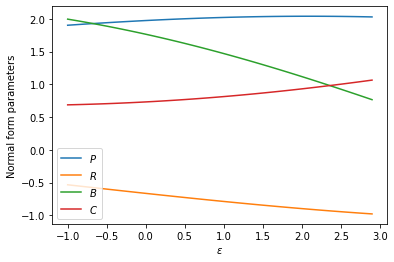

In [73]:
plt.plot(epsilons,uxx_func_fit(epsilons)/uxxxx_func_fit(epsilons), label='$P$')
plt.plot(epsilons,1-(r_func_fit(epsilons)-1)/uxxxx_func_fit(epsilons), label='$R$')
plt.plot(epsilons,-b3_func_fit(epsilons)/uxxxx_func_fit(epsilons), label='$B$')
plt.plot(epsilons,-b5_func_fit(epsilons)/uxxxx_func_fit(epsilons), label='$C$')
plt.xlabel(r'$\varepsilon$')
plt.ylabel('Normal form parameters')
plt.legend()
plt.show()

Stability of continuation orbits

In [49]:
evals_odd=[]
evecs_odd=[]
sols_odd=np.load('data/auto/odd_sols.npy')
pars_odd=np.load('data/auto/odd_pars.npy')
for i in range(len(sols_odd)):
    print(i,end='  \r')
    t,u=sols_odd[i].T
    epsilon,r,b3,b5,T,norm=pars_odd[i]
    u=u[::4]
    t=t[::4]
    t=T*t
    u=np.concatenate([u,-np.flip(u)[1:]])
    t=np.concatenate([t,t[-1]+np.cumsum(np.flip(np.diff(t)))])
                     
    fd=ps.FiniteDifference(d=2,axis=0,order=4,periodic=True)
    interior_coeffs=fd._coefficients(t)
    interior_inds=fd.stencil_inds
    slice_interior=slice((fd.n_stencil - 1) // 2, -(fd.n_stencil - 1) // 2)
    slice_boundary=np.concatenate(
                        [
                            np.arange(0, (fd.n_stencil - 1) // 2),
                            -np.flip(1 + np.arange(1, (fd.n_stencil - 1) // 2)),
                            np.array([-1]),
                        ]
                    )
    boundary_coeffs=fd._coefficients_boundary_periodic(t)
    boundary_inds=fd.stencil_inds

    dxx=np.zeros((len(t),len(t)))
    for i in range(len(interior_inds)):
        dxx[slice_interior][np.arange(len(interior_inds[i])),interior_inds[i]]=interior_coeffs[:,i].T
    for i in range(len(boundary_inds)):
        dxx[slice_boundary][np.arange(len(boundary_inds[i])),boundary_inds[i]]=boundary_coeffs[:,i].T


    fd=ps.FiniteDifference(d=4,axis=0,order=4,periodic=True)
    interior_coeffs=fd._coefficients(t)
    interior_inds=fd.stencil_inds
    slice_interior=slice((fd.n_stencil - 1) // 2, -(fd.n_stencil - 1) // 2)
    slice_boundary=np.concatenate(
                        [
                            np.arange(0, (fd.n_stencil - 1) // 2),
                            -np.flip(1 + np.arange(1, (fd.n_stencil - 1) // 2)),
                            np.array([-1]),
                        ]
                    )
    boundary_coeffs=fd._coefficients_boundary_periodic(t)
    boundary_inds=fd.stencil_inds

    dxxxx=np.zeros((len(t),len(t)))
    for i in range(len(interior_inds)):
        dxxxx[slice_interior][np.arange(len(interior_inds[i])),interior_inds[i]]=interior_coeffs[:,i].T
    for i in range(len(boundary_inds)):
        dxxxx[slice_boundary][np.arange(len(boundary_inds[i])),boundary_inds[i]]=boundary_coeffs[:,i].T
        
    vals,vecs=np.linalg.eig((r-1+3*b3*u**2-5*b5*u**4)*np.eye(len(t))-dxxxx-2*dxx)
    evals_odd=evals_odd+[vals]
    evecs_odd=evecs_odd+[vecs]

In [50]:
evals_even=[]
evecs_even=[]
sols_even=np.load('data/auto/even_sols.npy')
pars_even=np.load('data/auto/even_pars.npy')
for i in range(len(sols_even)):
    print(i,end='  \r')
    t,u=sols_even[i].T
    epsilon,r,b3,b5,T,norm=pars_even[i]
    u=u[::4]
    t=t[::4]
    t=T*t
    u=np.concatenate([u,-np.flip(u)[1:]])
    t=np.concatenate([t,t[-1]+np.cumsum(np.flip(np.diff(t)))])
                     
    fd=ps.FiniteDifference(d=2,axis=0,order=4,periodic=True)
    interior_coeffs=fd._coefficients(t)
    interior_inds=fd.stencil_inds
    slice_interior=slice((fd.n_stencil - 1) // 2, -(fd.n_stencil - 1) // 2)
    slice_boundary=np.concatenate(
                        [
                            np.arange(0, (fd.n_stencil - 1) // 2),
                            -np.flip(1 + np.arange(1, (fd.n_stencil - 1) // 2)),
                            np.array([-1]),
                        ]
                    )
    boundary_coeffs=fd._coefficients_boundary_periodic(t)
    boundary_inds=fd.stencil_inds

    dxx=np.zeros((len(t),len(t)))
    for i in range(len(interior_inds)):
        dxx[slice_interior][np.arange(len(interior_inds[i])),interior_inds[i]]=interior_coeffs[:,i].T
    for i in range(len(boundary_inds)):
        dxx[slice_boundary][np.arange(len(boundary_inds[i])),boundary_inds[i]]=boundary_coeffs[:,i].T


    fd=ps.FiniteDifference(d=4,axis=0,order=4,periodic=True)
    interior_coeffs=fd._coefficients(t)
    interior_inds=fd.stencil_inds
    slice_interior=slice((fd.n_stencil - 1) // 2, -(fd.n_stencil - 1) // 2)
    slice_boundary=np.concatenate(
                        [
                            np.arange(0, (fd.n_stencil - 1) // 2),
                            -np.flip(1 + np.arange(1, (fd.n_stencil - 1) // 2)),
                            np.array([-1]),
                        ]
                    )
    boundary_coeffs=fd._coefficients_boundary_periodic(t)
    boundary_inds=fd.stencil_inds

    dxxxx=np.zeros((len(t),len(t)))
    for i in range(len(interior_inds)):
        dxxxx[slice_interior][np.arange(len(interior_inds[i])),interior_inds[i]]=interior_coeffs[:,i].T
    for i in range(len(boundary_inds)):
        dxxxx[slice_boundary][np.arange(len(boundary_inds[i])),boundary_inds[i]]=boundary_coeffs[:,i].T
        
    vals,vecs=np.linalg.eig((r-1+3*b3*u**2-5*b5*u**4)*np.eye(len(t))-dxxxx-2*dxx)
    evals_even=evals_even+[vals]
    evecs_even=evecs_even+[vecs]

In [51]:
evals_periodic=[]
evecs_periodic=[]
sols_periodic=np.load('data/auto/periodic_sols.npy')
pars_periodic=np.load('data/auto/periodic_pars.npy')
for i in range(len(sols_periodic)):
    print(i,end='  \r')
    t,u=sols_periodic[i].T
    epsilon,r,b3,b5,T,norm=pars_periodic[i]
    u=u[::4]
    t=t[::4]
    t=T*t
    u=np.concatenate([u,-np.flip(u)[1:]])
    t=np.concatenate([t,t[-1]+np.cumsum(np.flip(np.diff(t)))])
                     
    fd=ps.FiniteDifference(d=2,axis=0,order=4,periodic=True)
    interior_coeffs=fd._coefficients(t)
    interior_inds=fd.stencil_inds
    slice_interior=slice((fd.n_stencil - 1) // 2, -(fd.n_stencil - 1) // 2)
    slice_boundary=np.concatenate(
                        [
                            np.arange(0, (fd.n_stencil - 1) // 2),
                            -np.flip(1 + np.arange(1, (fd.n_stencil - 1) // 2)),
                            np.array([-1]),
                        ]
                    )
    boundary_coeffs=fd._coefficients_boundary_periodic(t)
    boundary_inds=fd.stencil_inds

    dxx=np.zeros((len(t),len(t)))
    for i in range(len(interior_inds)):
        dxx[slice_interior][np.arange(len(interior_inds[i])),interior_inds[i]]=interior_coeffs[:,i].T
    for i in range(len(boundary_inds)):
        dxx[slice_boundary][np.arange(len(boundary_inds[i])),boundary_inds[i]]=boundary_coeffs[:,i].T


    fd=ps.FiniteDifference(d=4,axis=0,order=4,periodic=True)
    interior_coeffs=fd._coefficients(t)
    interior_inds=fd.stencil_inds
    slice_interior=slice((fd.n_stencil - 1) // 2, -(fd.n_stencil - 1) // 2)
    slice_boundary=np.concatenate(
                        [
                            np.arange(0, (fd.n_stencil - 1) // 2),
                            -np.flip(1 + np.arange(1, (fd.n_stencil - 1) // 2)),
                            np.array([-1]),
                        ]
                    )
    boundary_coeffs=fd._coefficients_boundary_periodic(t)
    boundary_inds=fd.stencil_inds

    dxxxx=np.zeros((len(t),len(t)))
    for i in range(len(interior_inds)):
        dxxxx[slice_interior][np.arange(len(interior_inds[i])),interior_inds[i]]=interior_coeffs[:,i].T
    for i in range(len(boundary_inds)):
        dxxxx[slice_boundary][np.arange(len(boundary_inds[i])),boundary_inds[i]]=boundary_coeffs[:,i].T
        
    vals,vecs=np.linalg.eig((r-1+3*b3*u**2-5*b5*u**4)*np.eye(len(t))-dxxxx-2*dxx)
    evals_periodic=evals_periodic+[vals]
    evecs_periodic=evecs_periodic+[vecs]

Plot the normal form parameters and continuation results

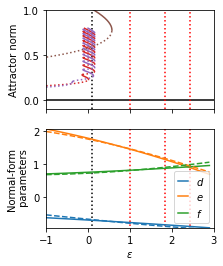

In [74]:
colors=['#ff7f0e', '#2ca02c', '#1f77b4','#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.subplots(2,1,figsize=(3,4))

plt.subplot(2,1,1)
plt.plot(np.arange(-1,4,1),np.zeros(5),c='black')
for epsilon in epsilons_train:
    plt.plot([epsilon,epsilon],[-0.1,1],ls=':',c='red')
plt.plot([0.1,0.1],[-0.1,1],ls=':',c='black')


inds=np.argsort(np.real(evals_odd))[:,-5:]
inds2=[inds[i][np.argsort(np.linalg.norm(evecs_odd[i][:,inds[i]],ord=1,axis=0))[-3:]] for i in range(len(inds))]
stableinds=np.where(np.all(np.real(np.array(evals_odd)[tuple([np.arange(len(evals_odd))[:,np.newaxis],inds2])])<1e-1,axis=1))[0]
unstableinds=np.where(np.any(np.real(np.array(evals_odd)[tuple([np.arange(len(evals_odd))[:,np.newaxis],inds2])])>1e-1,axis=1))[0]
for inds in np.split(stableinds, np.where(np.diff(stableinds) != 1)[0]+1):
    plt.plot(pars_odd[inds,0],pars_odd[inds,-1],c=colors[3])
for inds in np.split(unstableinds, np.where(np.diff(unstableinds) != 1)[0]+1):
    plt.plot(pars_odd[inds,0],pars_odd[inds,-1],ls=':',c=colors[3])
    
inds=np.argsort(np.real(evals_even))[:,-5:]
inds2=[inds[i][np.argsort(np.linalg.norm(evecs_even[i][:,inds[i]],ord=1,axis=0))[-3:]] for i in range(len(inds))]
stableinds=np.where(np.all(np.real(np.array(evals_even)[tuple([np.arange(len(evals_even))[:,np.newaxis],inds2])])<1e-1,axis=1))[0]
unstableinds=np.where(np.any(np.real(np.array(evals_even)[tuple([np.arange(len(evals_even))[:,np.newaxis],inds2])])>1e-1,axis=1))[0]
for inds in np.split(stableinds, np.where(np.diff(stableinds) != 1)[0]+1):
    plt.plot(pars_even[inds,0],pars_even[inds,-1],c=colors[4])
for inds in np.split(unstableinds, np.where(np.diff(unstableinds) != 1)[0]+1):
    plt.plot(pars_even[inds,0],pars_even[inds,-1],ls=':',c=colors[4])
    
inds=np.argsort(np.real(evals_periodic))[:,-5:]
inds2=[inds[i][np.argsort(np.linalg.norm(evecs_periodic[i][:,inds[i]],ord=1,axis=0))[-3:]] for i in range(len(inds))]
stableinds=np.where(np.all(np.real(np.array(evals_periodic)[tuple([np.arange(len(evals_periodic))[:,np.newaxis],inds2])])<1e-1,axis=1))[0]
unstableinds=np.where(np.any(np.real(np.array(evals_periodic)[tuple([np.arange(len(evals_periodic))[:,np.newaxis],inds2])])>1e-1,axis=1))[0]
for inds in np.split(stableinds, np.where(np.diff(stableinds) != 1)[0]+1):
    plt.plot(pars_periodic[inds,0],pars_periodic[inds,-1],c=colors[5])
for inds in np.split(unstableinds, np.where(np.diff(unstableinds) != 1)[0]+1):
    plt.plot(pars_periodic[inds,0],pars_periodic[inds,-1],ls=':',c=colors[5])

plt.xlim(-1,3)
plt.ylim(-0.1,1)
plt.ylabel('Attractor norm')
plt.gca().set_xticklabels([])

plt.subplot(2,1,2)
epsilons=np.arange(-1,3,0.1)
mn=np.min([r_func(epsilons),b3_func(epsilons),b5_func(epsilons)])
mx=np.max([r_func(epsilons),b3_func(epsilons),b5_func(epsilons)])
for epsilon in epsilons_train:
    plt.plot([epsilon,epsilon],[mx,mn],ls=':',c='red')
plt.plot([0.1,0.1],[mx,mn],ls=':',c='black')

line1=plt.plot(epsilons,r_func(epsilons), label='$d$')
line2=plt.plot(epsilons,b3_func(epsilons),label='$e$')
line3=plt.plot(epsilons,b5_func(epsilons),label='$f$')

plt.plot(epsilons,1-(r_func_fit(epsilons)-1)/uxxxx_func_fit(epsilons), c=line1[0].get_color(),ls='--')
plt.plot(epsilons,-b3_func_fit(epsilons)/uxxxx_func_fit(epsilons), c=line2[0].get_color(),ls='--')
plt.plot(epsilons,-b5_func_fit(epsilons)/uxxxx_func_fit(epsilons), c=line3[0].get_color(),ls='--')

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h, l,handlelength=1)
plt.ylim(mn,mx)
plt.xlim(-1,3)
plt.xlabel(r'$\varepsilon$')
plt.ylabel('Normal-form\n parameters')

plt.savefig('fig4a.pdf')
plt.show()
    

Extrapolate the model to parameters with twentry random initial conditions. The fit correctly predicts the localized states!

00 0.980


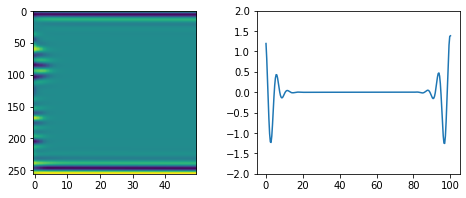

1


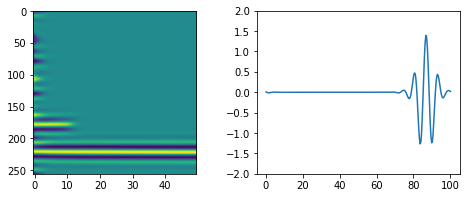

2


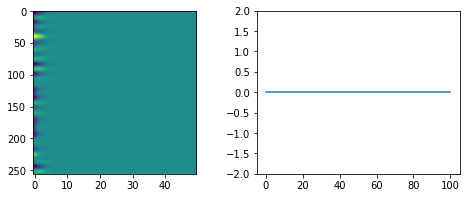

3


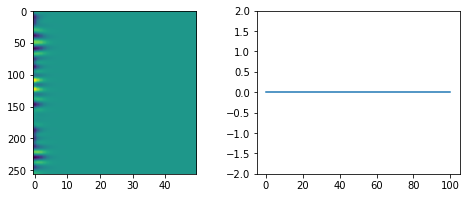

4


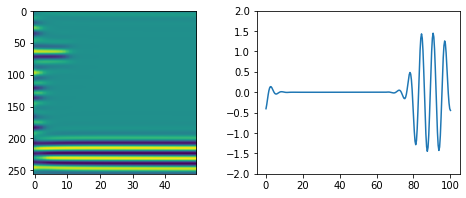

5


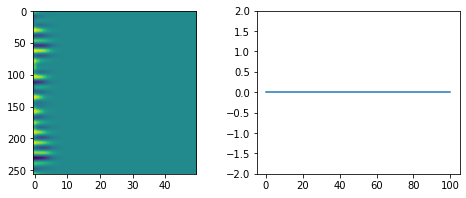

6


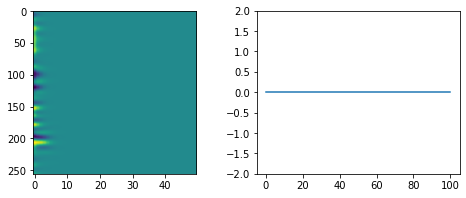

7


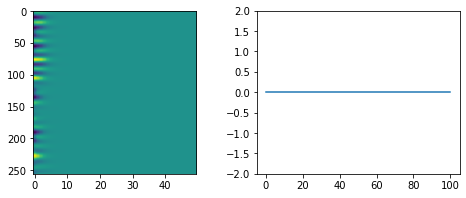

8


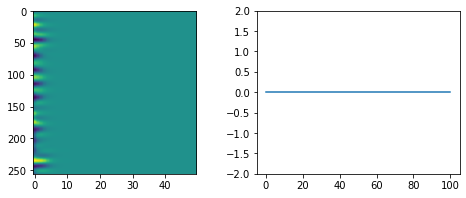

9


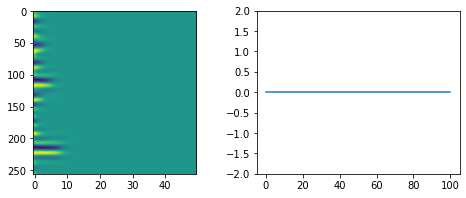

10


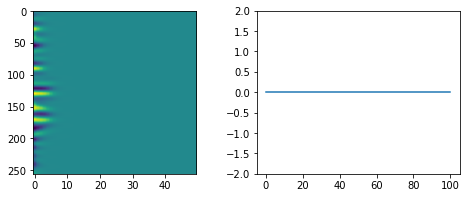

11


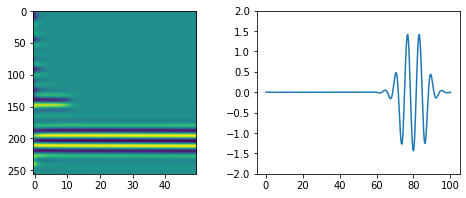

12


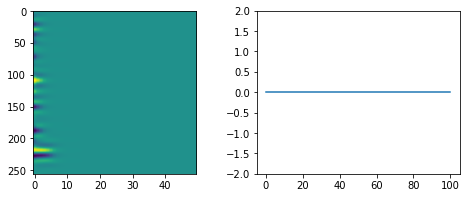

13


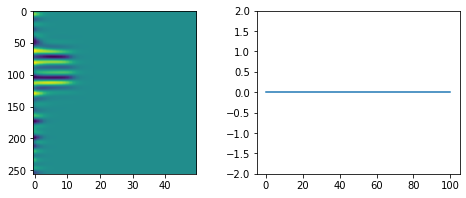

14


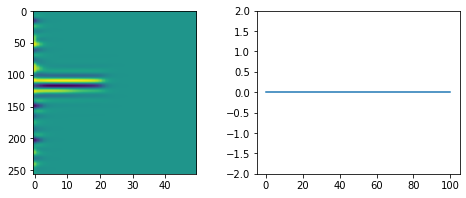

15


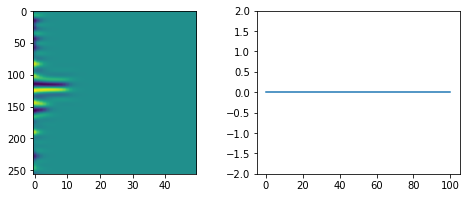

16


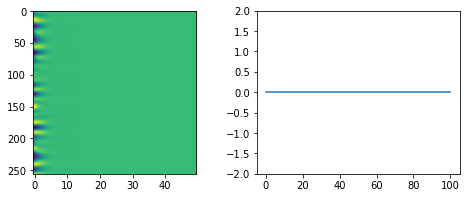

17


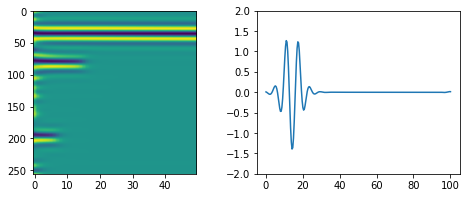

18


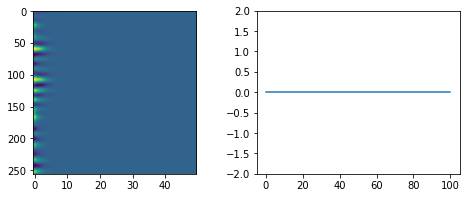

19


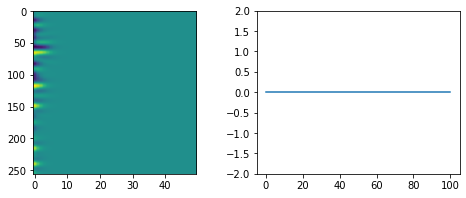

In [76]:
def sh_fit(t, u, epsilon):
    ux=np.real(ps.SpectralDerivative(d=1,axis=0)._differentiate(u,L/nx))
    uxx=np.real(ps.SpectralDerivative(d=2,axis=0)._differentiate(u,L/nx))
    uxxx=np.real(ps.SpectralDerivative(d=3,axis=0)._differentiate(u,L/nx))
    uxxxx=np.real(ps.SpectralDerivative(d=4,axis=0)._differentiate(u,L/nx))
    return ux_func_fit([epsilon])[0]*ux+uxx_func_fit([epsilon])[0]*uxx+uxxx_func_fit([epsilon])[0]*uxxx+uxxxx_func_fit([epsilon])[0]*uxxxx +\
                (r_func_fit([epsilon])[0]-1)*u+b3_func_fit([epsilon])[0]*u**3-b5_func_fit([epsilon])[0]*u**5

nx=256
N=nx
L=2*np.pi*16
t1=50
dt=1

epsilon=0.1
k=2

num_seeds=20
xs_test=[]
for i in range(1,num_seeds+1):
    np.random.seed(i)
    ks=np.arange(-20,21)/L
    u0=np.zeros((nx),dtype=np.complex128)
    scale0=0.5
    for kx in ks:
        scale=scale0/(1+np.abs(L*kx)**0.5)
        u0 += scale*(np.random.normal(0,1)+1j*np.random.normal(0,1))*np.exp(1j*(2*np.pi * kx * np.arange(nx)/nx*L)) 
    u=np.real(u0)
    us=np.zeros((int(t1/dt),nx))

    t=0
    for n in range(int(t1/dt)):
        t=n*dt
        print('%d %.3f'%(i, t/t1),end='\r')
        sol=solve_ivp(sh_fit, [t,t+dt], u, method='LSODA', args=(epsilon,), rtol=1e-6, atol=1e-6, first_step=dt/1000)
        u=sol.y[:,-1]
        us[n] = u
    xs_test.append(np.transpose(us)[:,:,np.newaxis])
    
for i in range(len(xs_test)):
    x=xs_test[i]
    print(i)
    plt.subplots(1,2,figsize=(8,3))
    plt.subplot(1,2,1)
    plt.imshow(x,aspect=1.0*x.shape[1]/nx)
    plt.subplot(1,2,2)
    plt.plot(np.arange(nx)/nx*L, x[:,-1])
    plt.ylim(-2,2)
    plt.show()

In [ ]:
plt.subplots(2,1,figsize=(3,4))

plt.subplot(2,1,1)
u=xs_test[12][:,-1]
ux=ps.SpectralDerivative(d=1,axis=0)._differentiate(u,L/nx)
u=np.roll(u,nx//2-np.argmax(ux)+1)
plt.plot(u,c=colors[3])
plt.ylim(-1.6,1.6)
plt.ylabel('$u$')
plt.gca().set_xticks([0,128,256])
plt.gca().set_xticklabels([])

plt.subplot(2,1,2)
u=xs_test[14][:,-1]
u=np.roll(u,nx//2-np.argmin(u)+1)
plt.plot(u,c=colors[4])
plt.ylim(-1.6,1.6)
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.gca().set_xticks([0,128,256])
plt.gca().set_xticklabels(['$-L/2$','$0$','$L/2$'])

plt.savefig('fig4b.pdf')

In [3]:
import matplotlib.pyplot as plt
from pysindy.utils import lorenz
import pysindy as ps
import numpy as np
from scipy.integrate import solve_ivp
from pysindy.utils import lorenz
import timeit
import os

In [83]:
from numpy.fft import fft2, ifft2
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-4
integrator_keywords['atol'] = 1e-4
integrator_keywords['method'] = 'LSODA'  # switch to RK45 integrator

epsilon=0.12
a=0.06
b=0.02
q=8e-4
f=2.3

d1 = 0.1
d2 = 0.1
L = 20  # Domain size in X and Y directions
n = 128  # Number of spatial points in each direction
N = n * n
x_uniform = np.linspace(-L / 2, L / 2, n + 1)
x = x_uniform[:n]
y = x_uniform[:n]
n2 = int(n / 2)
# Define Fourier wavevectors (kx, ky)
kx = (2 * np.pi / L) * np.hstack((np.linspace(0, n2 - 1, n2), 
                                  np.linspace(-n2, -1, n2)))
ky = kx
# Get 2D meshes in (x, y) and (kx, ky)
X, Y = np.meshgrid(x, y)
KX, KY = np.meshgrid(kx, ky)
K2 = KX ** 2 + KY ** 2
K22 = np.reshape(K2, (N, 1))

# Define the reaction-diffusion PDE in the Fourier (kx, ky) space
def reaction_diffusion(t, uvt):
    ut = np.reshape(uvt[:N], (n, n))
    vt = np.reshape(uvt[N : 2 * N], (n, n))
    u = np.real(ifft2(ut))
    v = np.real(ifft2(vt))
    u2 = u ** 2
    vu = v*(u-q*a)/(u+q*a)
    utrhs = np.reshape((fft2(1/epsilon*(a*u-u2-f*b*vu))), (N, 1))
    vtrhs = np.reshape((fft2(a*u-b*v)), (N, 1))
    uvt_reshaped = np.reshape(uvt, (len(uvt), 1))
    uvt_updated = np.squeeze(
        np.vstack(
            (-d1 * K22 * uvt_reshaped[:N] + utrhs, 
             -d2 * K22/epsilon * uvt_reshaped[N:] + vtrhs)
        )
    )
    return uvt_updated


# define our solution vectors
u0 = np.zeros((len(x), len(y)))
v0 = np.zeros((len(x), len(y)))

xm=1/2*((1-f-q)+((1-f-q)**2+4*q*(1+f))**0.5)
# Initial conditions (steady state plus perturbation)
u0[:,:] = a*xm
v0[:,:] = a**2*xm/b*(1+0.001*np.sin(2*np.pi*x[:,np.newaxis]/L)*np.sin(2*np.pi*y[np.newaxis,:]/L))

# uvt is the solution vector in Fourier space, so below
# we are initializing the 2D FFT of the initial condition, uvt0
uvt0 = np.squeeze(
    np.hstack(
        (np.reshape(fft2(u0), (1, N)), 
         np.reshape(fft2(v0), (1, N)))
    )
)

In [86]:
from numpy.fft import fft2, ifft2
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-4
integrator_keywords['atol'] = 1e-4
integrator_keywords['method'] = 'LSODA'  # switch to RK45 integrator

epsilon=0.12
a=0.06
b=0.02
q=8e-4
f=2.3

d1 = 0.1
d2 = 0.1
L = 20  # Domain size in X and Y directions
n = 128  # Number of spatial points in each direction
N = n * n
x_uniform = np.linspace(-L / 2, L / 2, n + 1)
x = x_uniform[:n]
y = x_uniform[:n]
X, Y = np.meshgrid(x, y)

# Define the reaction-diffusion PDE in the Fourier (kx, ky) space
def reaction_diffusion(t, uvt):
    ut = np.reshape(uvt[:N], (n, n))
    vt = np.reshape(uvt[N : 2 * N], (n, n))
    uxx=ps.SpectralDerivative(d=2,axis=0)._differentiate(ut,L/n)
    uyy=ps.SpectralDerivative(d=2,axis=1)._differentiate(ut,L/n)
    vxx=ps.SpectralDerivative(d=2,axis=0)._differentiate(vt,L/n)
    vyy=ps.SpectralDerivative(d=2,axis=1)._differentiate(vt,L/n)
    utrhs = -d1 * (uxx+uyy)/epsilon+1/epsilon*(a*ut-ut**2-f*b*vt*(ut-q*a)/(ut+q*a))
    vtrhs = -d2 * (vxx+vyy) +(a*ut-b*vt)
    uvt_updated = np.concatenate([utrhs.ravel(), vtrhs.ravel()])
    return uvt_updated


# define our solution vectors
u0 = np.zeros((len(x), len(y)))
v0 = np.zeros((len(x), len(y)))

xm=1/2*((1-f-q)+((1-f-q)**2+4*q*(1+f))**0.5)
# Initial conditions (steady state plus perturbation)
u0[:,:] = a*xm
v0[:,:] = a**2*xm/b*(1+0.001*np.sin(2*np.pi*x[:,np.newaxis]/L)*np.sin(2*np.pi*y[np.newaxis,:]/L))

# uvt is the solution vector in Fourier space, so below
# we are initializing the 2D FFT of the initial condition, uvt0
uvt0 = np.concatenate([u0.ravel(),v0.ravel()])

In [ ]:
t = np.linspace(0, 100, int(100 / 0.5))
# define our solution vectors
u = np.zeros((len(x), len(y), len(t)))
v = np.zeros((len(x), len(y), len(t)))

# Solve the PDE in the Fourier space, where it reduces to system of ODEs
start=timeit.default_timer()
uvsol = solve_ivp(
    reaction_diffusion, (t[0], t[-1]), y0=uvt0, t_eval=t, **integrator_keywords
)
stop=timeit.default_timer()
print(stop-start)
uvsol = uvsol.y

# Reshape things and ifft back into (x, y, t) space from (kx, ky, t) space
for j in range(len(t)):
    ut = np.reshape(uvsol[:N, j], (n, n))
    vt = np.reshape(uvsol[N:, j], (n, n))
    u[:, :, j] = np.real(ifft2(ut))
    v[:, :, j] = np.real(ifft2(vt))
    
plt.plot(t,np.mean(u/u0[:,:,np.newaxis],axis=(0,1)))
plt.plot(t,np.mean(v/v0[:,:,np.newaxis],axis=(0,1)))

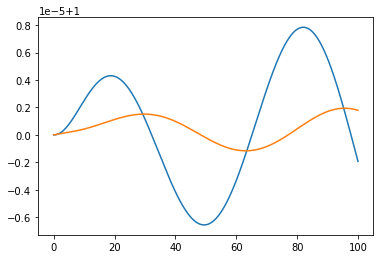

In [79]:
plt.plot(t,np.mean(u/u0[:,:,np.newaxis],axis=(0,1)))
plt.plot(t,np.mean(v/v0[:,:,np.newaxis],axis=(0,1)))

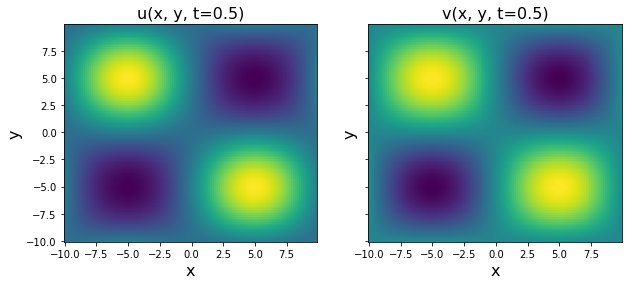

In [80]:
# Plot to check if spiral is nicely reproduced
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolor(X, Y, u[:, :, -1])
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title('u(x, y, t=0.5)', fontsize=16)
plt.subplot(1, 2, 2)
plt.pcolor(X, Y, v[:, :, -1])
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title('v(x, y, t=0.5)', fontsize=16)

dt = t[1] - t[0]
dx = x[1] - x[0]
dy = y[1] - y[0]

u_sol = u
v_sol = v